In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import time
from pickle import load
import tensorflow as tf
from tensorflow import keras
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")

    
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

tf.random.set_seed(42)
K = keras.backend

from sklearn.preprocessing import StandardScaler,PowerTransformer
import math
from scipy.stats import multivariate_normal
from scipy.stats import norm
import os
from helper import *

hr_data = np.load("training_dataset_with_y.npy")[:,:,2:]

hr_data_reshaped = hr_data.reshape((-1,8*32))

data = np.load("training_dataset.npy")[:,:,0]


training_data = data[:400,:]
hold_out_val = data[20000:30000]
hold_out = data[-30000:,:]

training_data_high_res = hr_data_reshaped[:400,:]
hold_out_val_high_res = hr_data_reshaped[20000:30000]
hold_out_high_res = hr_data_reshaped[-30000:,:]



training_data_scaled = (training_data - training_data.mean())/training_data.std()
hold_out_val_scaled = (hold_out_val-training_data.mean())/training_data.std()
hold_out_scaled = (hold_out-training_data.mean())/training_data.std()

training_data_scaled = np.expand_dims(training_data_scaled,axis=1)
hold_out_val_scaled = np.expand_dims(hold_out_val_scaled,axis=1)
hold_out_scaled = np.expand_dims(hold_out_scaled,axis=1)


training_data_hr_scaled = (training_data_high_res - training_data_high_res.mean())/training_data_high_res.std()
hold_out_hr_val_scaled = (hold_out_val_high_res-training_data_high_res.mean())/training_data_high_res.std()
hold_out_hr_scaled = (hold_out_high_res-training_data_high_res.mean())/training_data_high_res.std()


training_data_hr_scaled = np.expand_dims(training_data_hr_scaled,axis=1)
hold_out_hr_val_scaled = np.expand_dims(hold_out_hr_val_scaled,axis=1)
hold_out_hr_scaled = np.expand_dims(hold_out_hr_scaled,axis=1)


history_length = 100

k = 1

num_dims = 8
num_dims_hr = 256

#Prepare RNN sequences

def prepare_datasets_for_RNN(dataset,history_length,num_dims):
    dataset = dataset[:(dataset.shape[0]//history_length)*history_length,:] # to make it multiple of history
    dataset_shape = dataset.shape[0]
    reshaped = dataset.reshape(int(dataset_shape/history_length),history_length,k,num_dims)
    add_on = reshaped[1:,0,:,:]
    add_on = add_on.reshape(int(dataset_shape/history_length)-1,1,k,num_dims)
    reshaped = reshaped[:-1,:,:,:]
    concat = np.concatenate((reshaped,add_on),axis=1)
    concat = concat.reshape(((int(dataset_shape/history_length)-1)*(history_length+1),k,num_dims))
    concat = concat.reshape((k*(int(dataset_shape/history_length)-1)*(history_length+1),num_dims),order="F")
    features = concat.reshape(k*(int(dataset_shape/history_length)-1),(history_length+1),num_dims)
    
    return features



train_nn_features = prepare_datasets_for_RNN(training_data_scaled,history_length,num_dims)
valid_nn_features = prepare_datasets_for_RNN(hold_out_val_scaled,history_length,num_dims)
test_nn_features = hold_out_scaled.transpose([1,0,2])

train_hr_nn_features = prepare_datasets_for_RNN(training_data_hr_scaled,history_length,num_dims_hr)
valid_hr_nn_features =  prepare_datasets_for_RNN(hold_out_hr_val_scaled,history_length,num_dims_hr)
test_hr_nn_features =  hold_out_hr_scaled.transpose([1,0,2])

# RNN #

In [76]:
train_nn_input = train_nn_features[:,:-1,:]
train_nn_output = train_nn_features[:,1:,:]

train_hr_nn_input = train_hr_nn_features[:,:-1,:]
train_hr_nn_output = train_hr_nn_features[:,1:,:]

train_shape = train_nn_input.shape[0]


valid_nn_input = valid_nn_features[:,:-1,:]
valid_nn_output = valid_nn_features[:,1:,:]

valid_hr_nn_input = valid_hr_nn_features[:,:-1,:]
valid_hr_nn_output = valid_hr_nn_features[:,1:,:]

valid_shape = valid_nn_input.shape[0]


test_nn_input = test_nn_features[:,:-1,:]
test_nn_output = test_nn_features[:,1:,:]

test_hr_nn_input = test_hr_nn_features[:,:-1,:]
test_hr_nn_output = test_hr_nn_features[:,1:,:]

test_shape = test_nn_input.shape[0]

def loglik_gaussian_x(array,mean,sigma):
    term = -K.log(sigma**2 * 2*math.pi) - tf.math.divide((array-mean),sigma)**2
    loglik = 0.5*term
    return tf.math.reduce_sum(loglik,axis=[1,2])

def loglik_gaussian_hr(array,mean,sigma):
    term = -K.log(sigma**2 * 2*math.pi) - tf.math.divide((array-mean),sigma)**2
    loglik = 0.5*term
    return tf.math.reduce_sum(loglik,axis=[1,2])

def loss(loglikelihood_x):
    loglik = loglikelihood_x 
    loss = -loglik / history_length #to make it avg per spatial vector
    return tf.reduce_mean(loss)


def valid_loss(valid_list,simulator,sigma_x,hr=False):
    mean = simulator(valid_list,training=False)[0]
    if hr == False:
        return -np.mean(loglik_gaussian_x(valid_list[1],mean,sigma_x))
    if hr == True:
        return -np.mean(loglik_gaussian_x(valid_list[3],mean,sigma_x))

    
hidden_state_size = 32


hidden_in_train = np.zeros(shape=(train_shape,hidden_state_size))
input_list = [train_nn_input,train_nn_output,train_hr_nn_input,train_hr_nn_output,hidden_in_train]

hidden_in_test = np.zeros(shape=(test_shape,hidden_state_size))
test_list = [test_nn_input,test_nn_output,test_hr_nn_input,test_hr_nn_output,hidden_in_test]

hidden_in_valid = np.zeros(shape=(valid_shape,hidden_state_size))
valid_list = [valid_nn_input,valid_nn_output,valid_hr_nn_input,valid_hr_nn_output,hidden_in_valid]    

# No TL

0


2022-09-11 14:22:21.813952: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-11 14:22:22.522586: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7408 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:3b:00.0, compute capability: 6.1


Epoch 0/250


2022-09-11 14:22:23.797189: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-11 14:22:24.404939: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


3/3 [==============================] - trainLoss: 6.5739  Val_loss: 396.6445 
Epoch 1/250
3/3 [==============================] - trainLoss: 6.2773  Val_loss: 369.4964 
Epoch 2/250
3/3 [==============================] - trainLoss: 5.9475  Val_loss: 343.6866 
Epoch 3/250
3/3 [==============================] - trainLoss: 5.6240  Val_loss: 319.3636 
Epoch 4/250
3/3 [==============================] - trainLoss: 5.3609  Val_loss: 297.3579 
Epoch 5/250
3/3 [==============================] - trainLoss: 5.0459  Val_loss: 277.6837 
Epoch 6/250
3/3 [==============================] - trainLoss: 4.8206  Val_loss: 260.6567 
Epoch 7/250
3/3 [==============================] - trainLoss: 4.5851  Val_loss: 246.5046 
Epoch 8/250
3/3 [==============================] - trainLoss: 4.2573  Val_loss: 235.4475 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.0654  Val_loss: 228.0210 
Epoch 10/250
3/3 [==============================] - trainLoss: 3.8081  Val_loss: 224.6362 
Epoch 11/250
3/3 [===

3/3 [==============================] - trainLoss: -4.3528  Val_loss: 54.3480 
Epoch 54/250
3/3 [==============================] - trainLoss: -4.4484  Val_loss: 7.1046 
Epoch 55/250
3/3 [==============================] - trainLoss: -4.6200  Val_loss: -39.3920 
Epoch 56/250
3/3 [==============================] - trainLoss: -4.8810  Val_loss: -89.7102 
Epoch 57/250
3/3 [==============================] - trainLoss: -5.0434  Val_loss: -141.5522 
Epoch 58/250
3/3 [==============================] - trainLoss: -5.3803  Val_loss: -192.3857 
Epoch 59/250
3/3 [==============================] - trainLoss: -5.5545  Val_loss: -242.3281 
Epoch 60/250
3/3 [==============================] - trainLoss: -5.7436  Val_loss: -290.7131 
Epoch 61/250
3/3 [==============================] - trainLoss: -5.9792  Val_loss: -333.1230 
Epoch 62/250
3/3 [==============================] - trainLoss: -6.1718  Val_loss: -369.8976 
Epoch 63/250
3/3 [==============================] - trainLoss: -6.3458  Val_loss: -404.233

3/3 [==============================] - trainLoss: -18.6982  Val_loss: 2408.0842 
Epoch 175/250
3/3 [==============================] - trainLoss: -18.9793  Val_loss: 2432.1604 
Epoch 176/250
3/3 [==============================] - trainLoss: -18.7260  Val_loss: 2544.9146 
Epoch 177/250
3/3 [==============================] - trainLoss: -19.0084  Val_loss: 2747.8342 
Epoch 178/250
3/3 [==============================] - trainLoss: -18.8260  Val_loss: 2911.2314 
Epoch 179/250
3/3 [==============================] - trainLoss: -18.8768  Val_loss: 2964.1897 
Epoch 180/250
3/3 [==============================] - trainLoss: -18.7409  Val_loss: 2920.9656 
Epoch 181/250
3/3 [==============================] - trainLoss: -18.8127  Val_loss: 2912.3865 
Epoch 182/250
3/3 [==============================] - trainLoss: -19.1919  Val_loss: 2991.9817 
Epoch 183/250
3/3 [==============================] - trainLoss: -19.0097  Val_loss: 3111.7490 
Epoch 184/250
3/3 [==============================] - trainLoss: 

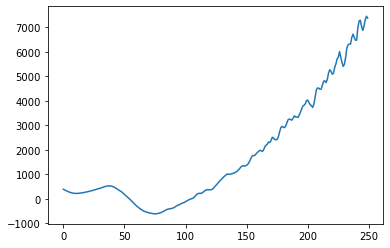

1
Epoch 0/250
3/3 [==============================] - trainLoss: 8.0993  Val_loss: 468.2894 
Epoch 1/250
3/3 [==============================] - trainLoss: 7.7565  Val_loss: 429.0027 
Epoch 2/250
3/3 [==============================] - trainLoss: 7.4322  Val_loss: 390.9812 
Epoch 3/250
3/3 [==============================] - trainLoss: 7.0055  Val_loss: 354.6685 
Epoch 4/250
3/3 [==============================] - trainLoss: 6.5920  Val_loss: 320.6295 
Epoch 5/250
3/3 [==============================] - trainLoss: 6.1502  Val_loss: 289.0750 
Epoch 6/250
3/3 [==============================] - trainLoss: 6.0929  Val_loss: 260.7469 
Epoch 7/250
3/3 [==============================] - trainLoss: 5.5931  Val_loss: 235.8398 
Epoch 8/250
3/3 [==============================] - trainLoss: 5.4321  Val_loss: 214.4233 
Epoch 9/250
3/3 [==============================] - trainLoss: 5.0452  Val_loss: 196.5546 
Epoch 10/250
3/3 [==============================] - trainLoss: 4.8305  Val_loss: 182.0717 
Epoch 1

3/3 [==============================] - trainLoss: -8.8036  Val_loss: -447.1574 
Epoch 81/250
3/3 [==============================] - trainLoss: -8.8430  Val_loss: -450.4656 
Epoch 82/250
3/3 [==============================] - trainLoss: -9.1223  Val_loss: -448.7646 
Epoch 83/250
3/3 [==============================] - trainLoss: -9.3053  Val_loss: -442.4969 
Epoch 84/250
3/3 [==============================] - trainLoss: -9.5531  Val_loss: -436.5269 
Epoch 85/250
3/3 [==============================] - trainLoss: -9.7077  Val_loss: -428.8557 
Epoch 86/250
3/3 [==============================] - trainLoss: -10.0457  Val_loss: -413.4212 
Epoch 87/250
3/3 [==============================] - trainLoss: -10.0380  Val_loss: -400.7340 
Epoch 88/250
3/3 [==============================] - trainLoss: -10.1907  Val_loss: -387.0916 
Epoch 89/250
3/3 [==============================] - trainLoss: -10.7828  Val_loss: -369.8563 
Epoch 90/250
3/3 [==============================] - trainLoss: -10.6778  Val_lo

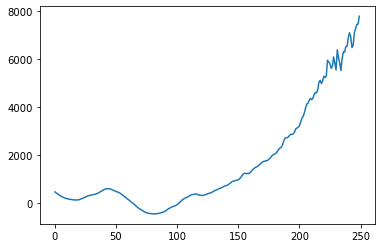

2
Epoch 0/250
3/3 [==============================] - trainLoss: 6.6531  Val_loss: 329.0508 
Epoch 1/250
3/3 [==============================] - trainLoss: 6.4749  Val_loss: 301.2948 
Epoch 2/250
3/3 [==============================] - trainLoss: 5.8729  Val_loss: 276.5007 
Epoch 3/250
3/3 [==============================] - trainLoss: 5.7756  Val_loss: 255.7110 
Epoch 4/250
3/3 [==============================] - trainLoss: 5.4041  Val_loss: 239.3624 
Epoch 5/250
3/3 [==============================] - trainLoss: 5.2368  Val_loss: 228.4753 
Epoch 6/250
3/3 [==============================] - trainLoss: 4.9200  Val_loss: 222.6570 
Epoch 7/250
3/3 [==============================] - trainLoss: 4.7091  Val_loss: 221.6841 
Epoch 8/250
3/3 [==============================] - trainLoss: 4.4093  Val_loss: 225.5450 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.2853  Val_loss: 233.2319 
Epoch 10/250
3/3 [==============================] - trainLoss: 4.0041  Val_loss: 242.4306 
Epoch 1

3/3 [==============================] - trainLoss: -5.3553  Val_loss: 167.6953 
Epoch 63/250
3/3 [==============================] - trainLoss: -5.6010  Val_loss: 143.8211 
Epoch 64/250
3/3 [==============================] - trainLoss: -5.6872  Val_loss: 115.5658 
Epoch 65/250
3/3 [==============================] - trainLoss: -6.1919  Val_loss: 85.8997 
Epoch 66/250
3/3 [==============================] - trainLoss: -6.1180  Val_loss: 53.2826 
Epoch 67/250
3/3 [==============================] - trainLoss: -6.6118  Val_loss: 24.8505 
Epoch 68/250
3/3 [==============================] - trainLoss: -6.4053  Val_loss: -8.3560 
Epoch 69/250
3/3 [==============================] - trainLoss: -7.1526  Val_loss: -32.3940 
Epoch 70/250
3/3 [==============================] - trainLoss: -7.2736  Val_loss: -51.9677 
Epoch 71/250
3/3 [==============================] - trainLoss: -7.4814  Val_loss: -72.5931 
Epoch 72/250
3/3 [==============================] - trainLoss: -7.3678  Val_loss: -101.4316 
Epoc

3/3 [==============================] - trainLoss: -10.5358  Val_loss: -328.2651 
Epoch 88/250
3/3 [==============================] - trainLoss: -10.7194  Val_loss: -353.0678 
Epoch 89/250
3/3 [==============================] - trainLoss: -11.0727  Val_loss: -378.3333 
Epoch 90/250
3/3 [==============================] - trainLoss: -11.3757  Val_loss: -407.2055 
Epoch 91/250
3/3 [==============================] - trainLoss: -11.7531  Val_loss: -427.4460 
Epoch 92/250
3/3 [==============================] - trainLoss: -11.6983  Val_loss: -442.0345 
Epoch 93/250
3/3 [==============================] - trainLoss: -11.8316  Val_loss: -441.6619 
Epoch 94/250
3/3 [==============================] - trainLoss: -11.9445  Val_loss: -435.8475 
Epoch 95/250
3/3 [==============================] - trainLoss: -11.9440  Val_loss: -427.8003 
Epoch 96/250
3/3 [==============================] - trainLoss: -12.4160  Val_loss: -421.5716 
Epoch 97/250
3/3 [==============================] - trainLoss: -12.4860  

3/3 [==============================] - trainLoss: -18.3386  Val_loss: 1362.5807 
Epoch 164/250
3/3 [==============================] - trainLoss: -18.4434  Val_loss: 1378.3601 
Epoch 165/250
3/3 [==============================] - trainLoss: -18.2334  Val_loss: 1424.2124 
Epoch 166/250
3/3 [==============================] - trainLoss: -18.2671  Val_loss: 1456.8514 
Epoch 167/250
3/3 [==============================] - trainLoss: -18.1180  Val_loss: 1506.5363 
Epoch 168/250
3/3 [==============================] - trainLoss: -18.2557  Val_loss: 1573.1952 
Epoch 169/250
3/3 [==============================] - trainLoss: -18.5959  Val_loss: 1648.4707 
Epoch 170/250
3/3 [==============================] - trainLoss: -18.5954  Val_loss: 1659.9552 
Epoch 171/250
3/3 [==============================] - trainLoss: -18.4660  Val_loss: 1671.4840 
Epoch 172/250
3/3 [==============================] - trainLoss: -18.7566  Val_loss: 1681.3011 
Epoch 173/250
3/3 [==============================] - trainLoss: 

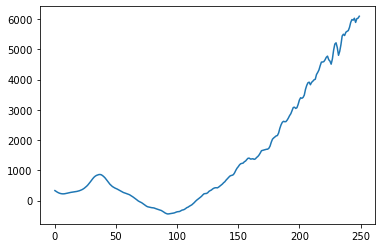

3
Epoch 0/250
3/3 [==============================] - trainLoss: 6.7260  Val_loss: 429.9685 
Epoch 1/250
3/3 [==============================] - trainLoss: 6.5203  Val_loss: 398.1750 
Epoch 2/250
3/3 [==============================] - trainLoss: 6.0583  Val_loss: 366.4911 
Epoch 3/250
3/3 [==============================] - trainLoss: 5.7785  Val_loss: 335.0696 
Epoch 4/250
3/3 [==============================] - trainLoss: 5.5936  Val_loss: 304.3058 
Epoch 5/250
3/3 [==============================] - trainLoss: 5.4019  Val_loss: 274.9821 
Epoch 6/250
3/3 [==============================] - trainLoss: 4.9397  Val_loss: 246.5205 
Epoch 7/250
3/3 [==============================] - trainLoss: 4.6972  Val_loss: 219.5784 
Epoch 8/250
3/3 [==============================] - trainLoss: 4.5554  Val_loss: 193.9634 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.1864  Val_loss: 170.2766 
Epoch 10/250
3/3 [==============================] - trainLoss: 3.9585  Val_loss: 148.2328 
Epoch 1

3/3 [==============================] - trainLoss: -8.4643  Val_loss: -317.6949 
Epoch 75/250
3/3 [==============================] - trainLoss: -8.5863  Val_loss: -332.4243 
Epoch 76/250
3/3 [==============================] - trainLoss: -8.8299  Val_loss: -344.2139 
Epoch 77/250
3/3 [==============================] - trainLoss: -8.8781  Val_loss: -361.3106 
Epoch 78/250
3/3 [==============================] - trainLoss: -9.3125  Val_loss: -371.8354 
Epoch 79/250
3/3 [==============================] - trainLoss: -9.3485  Val_loss: -379.8953 
Epoch 80/250
3/3 [==============================] - trainLoss: -9.8439  Val_loss: -388.3400 
Epoch 81/250
3/3 [==============================] - trainLoss: -9.6938  Val_loss: -388.4927 
Epoch 82/250
3/3 [==============================] - trainLoss: -10.1016  Val_loss: -389.6471 
Epoch 83/250
3/3 [==============================] - trainLoss: -10.1280  Val_loss: -386.3839 
Epoch 84/250
3/3 [==============================] - trainLoss: -10.4137  Val_loss

3/3 [==============================] - trainLoss: -16.1943  Val_loss: 155.7997 
Epoch 127/250
3/3 [==============================] - trainLoss: -16.5530  Val_loss: 177.0785 
Epoch 128/250
3/3 [==============================] - trainLoss: -16.5410  Val_loss: 184.2656 
Epoch 129/250
3/3 [==============================] - trainLoss: -16.7487  Val_loss: 194.0566 
Epoch 130/250
3/3 [==============================] - trainLoss: -16.6086  Val_loss: 213.5558 
Epoch 131/250
3/3 [==============================] - trainLoss: -16.9940  Val_loss: 241.6452 
Epoch 132/250
3/3 [==============================] - trainLoss: -17.0036  Val_loss: 274.3631 
Epoch 133/250
3/3 [==============================] - trainLoss: -16.7991  Val_loss: 322.6989 
Epoch 134/250
3/3 [==============================] - trainLoss: -16.7994  Val_loss: 376.7407 
Epoch 135/250
3/3 [==============================] - trainLoss: -16.6202  Val_loss: 417.9905 
Epoch 136/250
3/3 [==============================] - trainLoss: -16.7135  

3/3 [==============================] - trainLoss: -19.6043  Val_loss: 4206.7446 
Epoch 214/250
3/3 [==============================] - trainLoss: -19.1601  Val_loss: 4297.0684 
Epoch 215/250
3/3 [==============================] - trainLoss: -19.6224  Val_loss: 4411.2886 
Epoch 216/250
3/3 [==============================] - trainLoss: -19.8364  Val_loss: 4448.7505 
Epoch 217/250
3/3 [==============================] - trainLoss: -19.6041  Val_loss: 4554.4683 
Epoch 218/250
3/3 [==============================] - trainLoss: -19.5048  Val_loss: 4717.4678 
Epoch 219/250
3/3 [==============================] - trainLoss: -19.7028  Val_loss: 4744.1030 
Epoch 220/250
3/3 [==============================] - trainLoss: -19.6678  Val_loss: 4794.3564 
Epoch 221/250
3/3 [==============================] - trainLoss: -19.7319  Val_loss: 4849.5396 
Epoch 222/250
3/3 [==============================] - trainLoss: -19.5721  Val_loss: 5170.7017 
Epoch 223/250
3/3 [==============================] - trainLoss: 

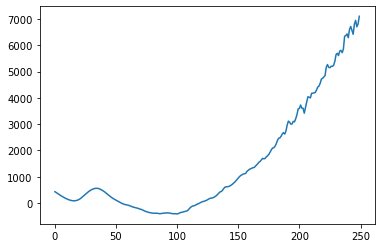

4
Epoch 0/250
3/3 [==============================] - trainLoss: 7.2340  Val_loss: 470.6820 
Epoch 1/250
3/3 [==============================] - trainLoss: 7.3682  Val_loss: 427.1523 
Epoch 2/250
3/3 [==============================] - trainLoss: 6.5186  Val_loss: 383.7789 
Epoch 3/250
3/3 [==============================] - trainLoss: 6.8829  Val_loss: 340.7317 
Epoch 4/250
3/3 [==============================] - trainLoss: 6.0820  Val_loss: 298.6148 
Epoch 5/250
3/3 [==============================] - trainLoss: 5.8404  Val_loss: 257.6991 
Epoch 6/250
3/3 [==============================] - trainLoss: 5.5004  Val_loss: 218.3274 
Epoch 7/250
3/3 [==============================] - trainLoss: 5.3203  Val_loss: 181.0621 
Epoch 8/250
3/3 [==============================] - trainLoss: 4.9190  Val_loss: 146.8337 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.8024  Val_loss: 116.1782 
Epoch 10/250
3/3 [==============================] - trainLoss: 4.3587  Val_loss: 89.2467 
Epoch 11

3/3 [==============================] - trainLoss: -9.6369  Val_loss: -554.7874 
Epoch 85/250
3/3 [==============================] - trainLoss: -10.0227  Val_loss: -567.1151 
Epoch 86/250
3/3 [==============================] - trainLoss: -10.2467  Val_loss: -578.7067 
Epoch 87/250
3/3 [==============================] - trainLoss: -10.5615  Val_loss: -592.9643 
Epoch 88/250
3/3 [==============================] - trainLoss: -10.5116  Val_loss: -598.1264 
Epoch 89/250
3/3 [==============================] - trainLoss: -10.7205  Val_loss: -602.4098 
Epoch 90/250
3/3 [==============================] - trainLoss: -10.9351  Val_loss: -603.2784 
Epoch 91/250
3/3 [==============================] - trainLoss: -11.2528  Val_loss: -593.7743 
Epoch 92/250
3/3 [==============================] - trainLoss: -11.3682  Val_loss: -581.3780 
Epoch 93/250
3/3 [==============================] - trainLoss: -11.6807  Val_loss: -568.6318 
Epoch 94/250
3/3 [==============================] - trainLoss: -11.8163  V

3/3 [==============================] - trainLoss: -17.6211  Val_loss: 1133.8241 
Epoch 158/250
3/3 [==============================] - trainLoss: -18.0823  Val_loss: 1194.0370 
Epoch 159/250
3/3 [==============================] - trainLoss: -17.8187  Val_loss: 1209.7848 
Epoch 160/250
3/3 [==============================] - trainLoss: -17.9540  Val_loss: 1211.2960 
Epoch 161/250
3/3 [==============================] - trainLoss: -18.0162  Val_loss: 1196.5004 
Epoch 162/250
3/3 [==============================] - trainLoss: -18.0972  Val_loss: 1201.6060 
Epoch 163/250
3/3 [==============================] - trainLoss: -18.0032  Val_loss: 1200.8048 
Epoch 164/250
3/3 [==============================] - trainLoss: -18.4013  Val_loss: 1200.2800 
Epoch 165/250
3/3 [==============================] - trainLoss: -18.4872  Val_loss: 1182.3311 
Epoch 166/250
3/3 [==============================] - trainLoss: -17.8995  Val_loss: 1185.7963 
Epoch 167/250
3/3 [==============================] - trainLoss: 

3/3 [==============================] - trainLoss: -20.0826  Val_loss: 6730.9077 
Epoch 245/250
3/3 [==============================] - trainLoss: -19.7354  Val_loss: 6878.5947 
Epoch 246/250
3/3 [==============================] - trainLoss: -20.0518  Val_loss: 6782.4658 
Epoch 247/250
3/3 [==============================] - trainLoss: -20.0330  Val_loss: 6586.4917 
Epoch 248/250
3/3 [==============================] - trainLoss: -19.9607  Val_loss: 6542.9282 
Epoch 249/250
3/3 [==============================] - trainLoss: -20.1157  Val_loss: 6749.5317 


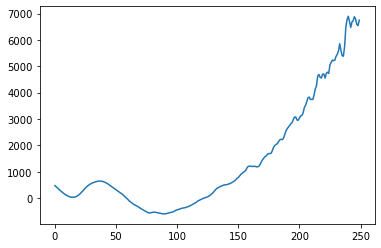

5
Epoch 0/250
3/3 [==============================] - trainLoss: 6.8442  Val_loss: 426.4611 
Epoch 1/250
3/3 [==============================] - trainLoss: 6.5819  Val_loss: 394.5789 
Epoch 2/250
3/3 [==============================] - trainLoss: 6.0138  Val_loss: 363.2652 
Epoch 3/250
3/3 [==============================] - trainLoss: 5.8809  Val_loss: 332.7986 
Epoch 4/250
3/3 [==============================] - trainLoss: 5.2885  Val_loss: 303.8963 
Epoch 5/250
3/3 [==============================] - trainLoss: 5.2175  Val_loss: 276.1860 
Epoch 6/250
3/3 [==============================] - trainLoss: 4.7565  Val_loss: 250.6963 
Epoch 7/250
3/3 [==============================] - trainLoss: 4.6154  Val_loss: 226.7920 
Epoch 8/250
3/3 [==============================] - trainLoss: 4.3684  Val_loss: 204.3424 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.0965  Val_loss: 183.6812 
Epoch 10/250
3/3 [==============================] - trainLoss: 3.8441  Val_loss: 164.7005 
Epoch 1

3/3 [==============================] - trainLoss: 0.6294  Val_loss: 55.2241 
Epoch 27/250
3/3 [==============================] - trainLoss: 0.2927  Val_loss: 60.2182 
Epoch 28/250
3/3 [==============================] - trainLoss: 0.3645  Val_loss: 69.3614 
Epoch 29/250
3/3 [==============================] - trainLoss: 0.0001  Val_loss: 78.3914 
Epoch 30/250
3/3 [==============================] - trainLoss: 0.0558  Val_loss: 89.2805 
Epoch 31/250
3/3 [==============================] - trainLoss: -0.1890  Val_loss: 102.3713 
Epoch 32/250
3/3 [==============================] - trainLoss: -0.3014  Val_loss: 114.4818 
Epoch 33/250
3/3 [==============================] - trainLoss: -0.5271  Val_loss: 123.0732 
Epoch 34/250
3/3 [==============================] - trainLoss: -0.7141  Val_loss: 127.3861 
Epoch 35/250
3/3 [==============================] - trainLoss: -1.0202  Val_loss: 125.7337 
Epoch 36/250
3/3 [==============================] - trainLoss: -1.1505  Val_loss: 117.3621 
Epoch 37/25

3/3 [==============================] - trainLoss: -6.4454  Val_loss: -565.6813 
Epoch 64/250
3/3 [==============================] - trainLoss: -6.6553  Val_loss: -566.8556 
Epoch 65/250
3/3 [==============================] - trainLoss: -6.8185  Val_loss: -569.4055 
Epoch 66/250
3/3 [==============================] - trainLoss: -6.9734  Val_loss: -565.5811 
Epoch 67/250
3/3 [==============================] - trainLoss: -7.2350  Val_loss: -563.8831 
Epoch 68/250
3/3 [==============================] - trainLoss: -7.3749  Val_loss: -556.1966 
Epoch 69/250
3/3 [==============================] - trainLoss: -7.5497  Val_loss: -545.1995 
Epoch 70/250
3/3 [==============================] - trainLoss: -7.4896  Val_loss: -533.4857 
Epoch 71/250
3/3 [==============================] - trainLoss: -7.8807  Val_loss: -529.3042 
Epoch 72/250
3/3 [==============================] - trainLoss: -7.9064  Val_loss: -526.2433 
Epoch 73/250
3/3 [==============================] - trainLoss: -8.4912  Val_loss: -

3/3 [==============================] - trainLoss: -17.4294  Val_loss: 1108.5894 
Epoch 144/250
3/3 [==============================] - trainLoss: -17.2981  Val_loss: 1152.3829 
Epoch 145/250
3/3 [==============================] - trainLoss: -17.4254  Val_loss: 1188.9955 
Epoch 146/250
3/3 [==============================] - trainLoss: -17.2735  Val_loss: 1216.1289 
Epoch 147/250
3/3 [==============================] - trainLoss: -17.7597  Val_loss: 1242.2319 
Epoch 148/250
3/3 [==============================] - trainLoss: -18.0176  Val_loss: 1255.8264 
Epoch 149/250
3/3 [==============================] - trainLoss: -17.8831  Val_loss: 1269.9238 
Epoch 150/250
3/3 [==============================] - trainLoss: -17.7246  Val_loss: 1304.5507 
Epoch 151/250
3/3 [==============================] - trainLoss: -17.7038  Val_loss: 1349.7296 
Epoch 152/250
3/3 [==============================] - trainLoss: -17.7607  Val_loss: 1371.7850 
Epoch 153/250
3/3 [==============================] - trainLoss: 

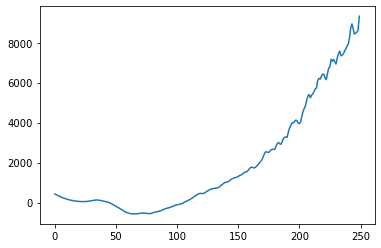

6
Epoch 0/250
3/3 [==============================] - trainLoss: 6.0221  Val_loss: 380.4318 
Epoch 1/250
3/3 [==============================] - trainLoss: 5.5458  Val_loss: 345.6186 
Epoch 2/250
3/3 [==============================] - trainLoss: 5.1870  Val_loss: 312.2719 
Epoch 3/250
3/3 [==============================] - trainLoss: 4.8664  Val_loss: 281.0194 
Epoch 4/250
3/3 [==============================] - trainLoss: 4.5079  Val_loss: 251.8651 
Epoch 5/250
3/3 [==============================] - trainLoss: 4.3927  Val_loss: 225.4221 
Epoch 6/250
3/3 [==============================] - trainLoss: 4.0063  Val_loss: 202.0480 
Epoch 7/250
3/3 [==============================] - trainLoss: 3.6994  Val_loss: 181.0500 
Epoch 8/250
3/3 [==============================] - trainLoss: 3.3957  Val_loss: 163.4498 
Epoch 9/250
3/3 [==============================] - trainLoss: 3.2391  Val_loss: 149.2844 
Epoch 10/250
3/3 [==============================] - trainLoss: 2.8574  Val_loss: 140.0988 
Epoch 1

3/3 [==============================] - trainLoss: -5.7586  Val_loss: 445.2319 
Epoch 57/250
3/3 [==============================] - trainLoss: -6.0181  Val_loss: 433.7291 
Epoch 58/250
3/3 [==============================] - trainLoss: -6.0538  Val_loss: 425.1965 
Epoch 59/250
3/3 [==============================] - trainLoss: -6.4991  Val_loss: 406.5298 
Epoch 60/250
3/3 [==============================] - trainLoss: -6.7758  Val_loss: 387.9944 
Epoch 61/250
3/3 [==============================] - trainLoss: -6.6449  Val_loss: 370.0143 
Epoch 62/250
3/3 [==============================] - trainLoss: -7.0055  Val_loss: 346.1821 
Epoch 63/250
3/3 [==============================] - trainLoss: -7.1805  Val_loss: 320.7155 
Epoch 64/250
3/3 [==============================] - trainLoss: -7.5762  Val_loss: 297.8096 
Epoch 65/250
3/3 [==============================] - trainLoss: -7.5508  Val_loss: 276.8163 
Epoch 66/250
3/3 [==============================] - trainLoss: -7.9019  Val_loss: 262.2855 
E

3/3 [==============================] - trainLoss: -16.4276  Val_loss: 653.7291 
Epoch 123/250
3/3 [==============================] - trainLoss: -15.9995  Val_loss: 693.1824 
Epoch 124/250
3/3 [==============================] - trainLoss: -16.7634  Val_loss: 699.5789 
Epoch 125/250
3/3 [==============================] - trainLoss: -16.2297  Val_loss: 708.1686 
Epoch 126/250
3/3 [==============================] - trainLoss: -16.5297  Val_loss: 720.6147 
Epoch 127/250
3/3 [==============================] - trainLoss: -16.9435  Val_loss: 790.4322 
Epoch 128/250
3/3 [==============================] - trainLoss: -16.7445  Val_loss: 847.3212 
Epoch 129/250
3/3 [==============================] - trainLoss: -17.0331  Val_loss: 880.2012 
Epoch 130/250
3/3 [==============================] - trainLoss: -17.1176  Val_loss: 885.1007 
Epoch 131/250
3/3 [==============================] - trainLoss: -16.6888  Val_loss: 881.0553 
Epoch 132/250
3/3 [==============================] - trainLoss: -17.1505  

3/3 [==============================] - trainLoss: -19.3781  Val_loss: 4607.7192 
Epoch 211/250
3/3 [==============================] - trainLoss: -19.1663  Val_loss: 4727.6997 
Epoch 212/250
3/3 [==============================] - trainLoss: -19.7760  Val_loss: 4752.7314 
Epoch 213/250
3/3 [==============================] - trainLoss: -19.1976  Val_loss: 4788.6050 
Epoch 214/250
3/3 [==============================] - trainLoss: -19.6714  Val_loss: 4769.6440 
Epoch 215/250
3/3 [==============================] - trainLoss: -19.5146  Val_loss: 4690.2139 
Epoch 216/250
3/3 [==============================] - trainLoss: -19.5776  Val_loss: 4622.3926 
Epoch 217/250
3/3 [==============================] - trainLoss: -19.4146  Val_loss: 4769.1958 
Epoch 218/250
3/3 [==============================] - trainLoss: -19.7708  Val_loss: 4981.2559 
Epoch 219/250
3/3 [==============================] - trainLoss: -19.3753  Val_loss: 5009.2881 
Epoch 220/250
3/3 [==============================] - trainLoss: 

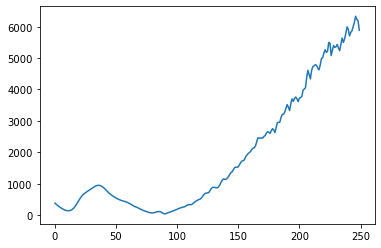

7
Epoch 0/250
3/3 [==============================] - trainLoss: 6.8261  Val_loss: 396.0155 
Epoch 1/250
3/3 [==============================] - trainLoss: 6.4138  Val_loss: 361.9725 
Epoch 2/250
3/3 [==============================] - trainLoss: 6.2152  Val_loss: 328.9483 
Epoch 3/250
3/3 [==============================] - trainLoss: 5.8267  Val_loss: 296.7406 
Epoch 4/250
3/3 [==============================] - trainLoss: 5.4787  Val_loss: 265.8208 
Epoch 5/250
3/3 [==============================] - trainLoss: 5.3207  Val_loss: 236.4678 
Epoch 6/250
3/3 [==============================] - trainLoss: 4.9176  Val_loss: 208.6837 
Epoch 7/250
3/3 [==============================] - trainLoss: 4.8636  Val_loss: 182.6765 
Epoch 8/250
3/3 [==============================] - trainLoss: 4.4753  Val_loss: 158.3967 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.3417  Val_loss: 136.6989 
Epoch 10/250
3/3 [==============================] - trainLoss: 4.1664  Val_loss: 117.6170 
Epoch 1

3/3 [==============================] - trainLoss: -10.2323  Val_loss: -420.5877 
Epoch 86/250
3/3 [==============================] - trainLoss: -10.3624  Val_loss: -426.7660 
Epoch 87/250
3/3 [==============================] - trainLoss: -10.7579  Val_loss: -429.0733 
Epoch 88/250
3/3 [==============================] - trainLoss: -10.6961  Val_loss: -430.2279 
Epoch 89/250
3/3 [==============================] - trainLoss: -11.0470  Val_loss: -418.9240 
Epoch 90/250
3/3 [==============================] - trainLoss: -11.2723  Val_loss: -408.0673 
Epoch 91/250
3/3 [==============================] - trainLoss: -11.4594  Val_loss: -391.6044 
Epoch 92/250
3/3 [==============================] - trainLoss: -11.6904  Val_loss: -364.9337 
Epoch 93/250
3/3 [==============================] - trainLoss: -11.8662  Val_loss: -336.3571 
Epoch 94/250
3/3 [==============================] - trainLoss: -11.8072  Val_loss: -316.1470 
Epoch 95/250
3/3 [==============================] - trainLoss: -12.0934  

3/3 [==============================] - trainLoss: -17.6674  Val_loss: 1331.8287 
Epoch 166/250
3/3 [==============================] - trainLoss: -18.1708  Val_loss: 1390.1892 
Epoch 167/250
3/3 [==============================] - trainLoss: -18.0488  Val_loss: 1445.5901 
Epoch 168/250
3/3 [==============================] - trainLoss: -18.3690  Val_loss: 1462.6367 
Epoch 169/250
3/3 [==============================] - trainLoss: -18.0124  Val_loss: 1480.6660 
Epoch 170/250
3/3 [==============================] - trainLoss: -18.2192  Val_loss: 1509.9037 
Epoch 171/250
3/3 [==============================] - trainLoss: -18.1778  Val_loss: 1558.1367 
Epoch 172/250
3/3 [==============================] - trainLoss: -18.0798  Val_loss: 1599.5873 
Epoch 173/250
3/3 [==============================] - trainLoss: -18.4392  Val_loss: 1634.7544 
Epoch 174/250
3/3 [==============================] - trainLoss: -18.3924  Val_loss: 1652.1234 
Epoch 175/250
3/3 [==============================] - trainLoss: 

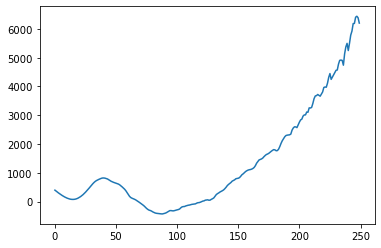

8
Epoch 0/250
3/3 [==============================] - trainLoss: 6.0680  Val_loss: 289.4476 
Epoch 1/250
3/3 [==============================] - trainLoss: 5.8578  Val_loss: 245.7725 
Epoch 2/250
3/3 [==============================] - trainLoss: 5.6125  Val_loss: 201.9931 
Epoch 3/250
3/3 [==============================] - trainLoss: 5.2098  Val_loss: 158.5881 
Epoch 4/250
3/3 [==============================] - trainLoss: 4.8781  Val_loss: 115.7750 
Epoch 5/250
3/3 [==============================] - trainLoss: 4.6284  Val_loss: 74.2088 
Epoch 6/250
3/3 [==============================] - trainLoss: 4.3429  Val_loss: 33.9640 
Epoch 7/250
3/3 [==============================] - trainLoss: 4.3113  Val_loss: -4.3829 
Epoch 8/250
3/3 [==============================] - trainLoss: 3.7398  Val_loss: -40.0312 
Epoch 9/250
3/3 [==============================] - trainLoss: 3.4579  Val_loss: -72.0453 
Epoch 10/250
3/3 [==============================] - trainLoss: 3.0382  Val_loss: -99.6384 
Epoch 11/2

3/3 [==============================] - trainLoss: -4.1330  Val_loss: 169.7280 
Epoch 50/250
3/3 [==============================] - trainLoss: -4.3158  Val_loss: 166.4109 
Epoch 51/250
3/3 [==============================] - trainLoss: -4.6305  Val_loss: 171.5824 
Epoch 52/250
3/3 [==============================] - trainLoss: -4.7646  Val_loss: 186.7106 
Epoch 53/250
3/3 [==============================] - trainLoss: -4.9026  Val_loss: 203.4738 
Epoch 54/250
3/3 [==============================] - trainLoss: -5.0273  Val_loss: 216.2776 
Epoch 55/250
3/3 [==============================] - trainLoss: -5.2884  Val_loss: 223.6161 
Epoch 56/250
3/3 [==============================] - trainLoss: -5.5092  Val_loss: 215.7167 
Epoch 57/250
3/3 [==============================] - trainLoss: -5.6349  Val_loss: 202.0584 
Epoch 58/250
3/3 [==============================] - trainLoss: -5.7829  Val_loss: 178.7352 
Epoch 59/250
3/3 [==============================] - trainLoss: -6.1288  Val_loss: 144.6587 
E

3/3 [==============================] - trainLoss: -19.1353  Val_loss: 3183.2834 
Epoch 185/250
3/3 [==============================] - trainLoss: -18.8568  Val_loss: 3246.8347 
Epoch 186/250
3/3 [==============================] - trainLoss: -19.1598  Val_loss: 3269.6565 
Epoch 187/250
3/3 [==============================] - trainLoss: -19.1509  Val_loss: 3295.7539 
Epoch 188/250
3/3 [==============================] - trainLoss: -19.2090  Val_loss: 3372.5474 
Epoch 189/250
3/3 [==============================] - trainLoss: -19.1522  Val_loss: 3491.0891 
Epoch 190/250
3/3 [==============================] - trainLoss: -19.3387  Val_loss: 3579.2798 
Epoch 191/250
3/3 [==============================] - trainLoss: -19.1140  Val_loss: 3640.9246 
Epoch 192/250
3/3 [==============================] - trainLoss: -19.2640  Val_loss: 3562.7837 
Epoch 193/250
3/3 [==============================] - trainLoss: -19.3403  Val_loss: 3639.8784 
Epoch 194/250
3/3 [==============================] - trainLoss: 

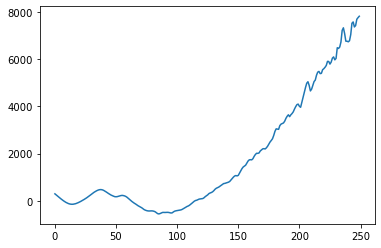

9
Epoch 0/250
3/3 [==============================] - trainLoss: 8.0524  Val_loss: 449.0524 
Epoch 1/250
3/3 [==============================] - trainLoss: 7.5391  Val_loss: 404.7914 
Epoch 2/250
3/3 [==============================] - trainLoss: 7.3356  Val_loss: 360.4786 
Epoch 3/250
3/3 [==============================] - trainLoss: 6.7660  Val_loss: 316.2984 
Epoch 4/250
3/3 [==============================] - trainLoss: 6.5284  Val_loss: 273.0850 
Epoch 5/250
3/3 [==============================] - trainLoss: 6.1744  Val_loss: 231.4266 
Epoch 6/250
3/3 [==============================] - trainLoss: 5.4529  Val_loss: 192.2462 
Epoch 7/250
3/3 [==============================] - trainLoss: 5.4801  Val_loss: 156.1204 
Epoch 8/250
3/3 [==============================] - trainLoss: 4.9279  Val_loss: 123.9773 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.6994  Val_loss: 96.5254 
Epoch 10/250
3/3 [==============================] - trainLoss: 4.2896  Val_loss: 73.7693 
Epoch 11/

3/3 [==============================] - trainLoss: 0.0561  Val_loss: 266.6248 
Epoch 35/250
3/3 [==============================] - trainLoss: -0.1599  Val_loss: 302.2589 
Epoch 36/250
3/3 [==============================] - trainLoss: -0.2640  Val_loss: 337.9197 
Epoch 37/250
3/3 [==============================] - trainLoss: -0.3115  Val_loss: 372.6004 
Epoch 38/250
3/3 [==============================] - trainLoss: -0.5143  Val_loss: 405.0050 
Epoch 39/250
3/3 [==============================] - trainLoss: -0.9177  Val_loss: 437.4782 
Epoch 40/250
3/3 [==============================] - trainLoss: -1.0211  Val_loss: 461.6351 
Epoch 41/250
3/3 [==============================] - trainLoss: -1.2230  Val_loss: 483.5715 
Epoch 42/250
3/3 [==============================] - trainLoss: -1.3310  Val_loss: 496.1316 
Epoch 43/250
3/3 [==============================] - trainLoss: -1.6693  Val_loss: 503.1490 
Epoch 44/250
3/3 [==============================] - trainLoss: -1.8495  Val_loss: 504.3559 
Ep

3/3 [==============================] - trainLoss: -9.0329  Val_loss: -386.2617 
Epoch 84/250
3/3 [==============================] - trainLoss: -9.2080  Val_loss: -401.8080 
Epoch 85/250
3/3 [==============================] - trainLoss: -9.7165  Val_loss: -423.3694 
Epoch 86/250
3/3 [==============================] - trainLoss: -9.7465  Val_loss: -451.3838 
Epoch 87/250
3/3 [==============================] - trainLoss: -9.9716  Val_loss: -478.4854 
Epoch 88/250
3/3 [==============================] - trainLoss: -10.0908  Val_loss: -501.0047 
Epoch 89/250
3/3 [==============================] - trainLoss: -10.3255  Val_loss: -518.5011 
Epoch 90/250
3/3 [==============================] - trainLoss: -10.5424  Val_loss: -526.5466 
Epoch 91/250
3/3 [==============================] - trainLoss: -10.7524  Val_loss: -533.0695 
Epoch 92/250
3/3 [==============================] - trainLoss: -10.7850  Val_loss: -532.2820 
Epoch 93/250
3/3 [==============================] - trainLoss: -11.3991  Val_l

3/3 [==============================] - trainLoss: -16.6356  Val_loss: 265.6069 
Epoch 140/250
3/3 [==============================] - trainLoss: -16.7923  Val_loss: 310.5212 
Epoch 141/250
3/3 [==============================] - trainLoss: -17.0948  Val_loss: 351.6866 
Epoch 142/250
3/3 [==============================] - trainLoss: -17.0464  Val_loss: 403.1856 
Epoch 143/250
3/3 [==============================] - trainLoss: -17.2861  Val_loss: 458.7023 
Epoch 144/250
3/3 [==============================] - trainLoss: -17.0942  Val_loss: 522.4888 
Epoch 145/250
3/3 [==============================] - trainLoss: -16.8763  Val_loss: 589.6524 
Epoch 146/250
3/3 [==============================] - trainLoss: -17.0421  Val_loss: 643.3752 
Epoch 147/250
3/3 [==============================] - trainLoss: -17.0085  Val_loss: 685.9824 
Epoch 148/250
3/3 [==============================] - trainLoss: -17.4457  Val_loss: 731.7028 
Epoch 149/250
3/3 [==============================] - trainLoss: -17.4830  

3/3 [==============================] - trainLoss: -19.4572  Val_loss: 4386.9551 
Epoch 227/250
3/3 [==============================] - trainLoss: -19.3695  Val_loss: 4413.8193 
Epoch 228/250
3/3 [==============================] - trainLoss: -19.6405  Val_loss: 4346.4370 
Epoch 229/250
3/3 [==============================] - trainLoss: -19.4346  Val_loss: 4321.2290 
Epoch 230/250
3/3 [==============================] - trainLoss: -19.7570  Val_loss: 4418.6270 
Epoch 231/250
3/3 [==============================] - trainLoss: -19.5008  Val_loss: 4524.6089 
Epoch 232/250
3/3 [==============================] - trainLoss: -19.9786  Val_loss: 4730.3086 
Epoch 233/250
3/3 [==============================] - trainLoss: -19.5767  Val_loss: 4777.6880 
Epoch 234/250
3/3 [==============================] - trainLoss: -19.7957  Val_loss: 4947.3569 
Epoch 235/250
3/3 [==============================] - trainLoss: -19.5348  Val_loss: 4922.7397 
Epoch 236/250
3/3 [==============================] - trainLoss: 

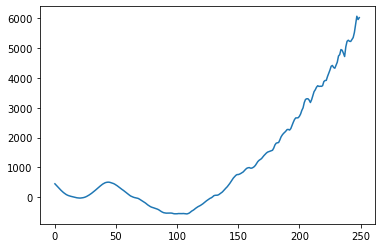

10
Epoch 0/250
3/3 [==============================] - trainLoss: 6.6627  Val_loss: 323.9313 
Epoch 1/250
3/3 [==============================] - trainLoss: 6.3464  Val_loss: 277.1823 
Epoch 2/250
3/3 [==============================] - trainLoss: 5.9541  Val_loss: 231.0653 
Epoch 3/250
3/3 [==============================] - trainLoss: 5.6207  Val_loss: 185.8438 
Epoch 4/250
3/3 [==============================] - trainLoss: 5.4162  Val_loss: 141.8203 
Epoch 5/250
3/3 [==============================] - trainLoss: 5.0242  Val_loss: 98.9384 
Epoch 6/250
3/3 [==============================] - trainLoss: 4.7208  Val_loss: 57.5423 
Epoch 7/250
3/3 [==============================] - trainLoss: 4.5743  Val_loss: 17.6333 
Epoch 8/250
3/3 [==============================] - trainLoss: 4.4607  Val_loss: -20.6283 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.0020  Val_loss: -57.0465 
Epoch 10/250
3/3 [==============================] - trainLoss: 3.8095  Val_loss: -91.5179 
Epoch 11/

3/3 [==============================] - trainLoss: 1.1480  Val_loss: -337.7793 
Epoch 25/250
3/3 [==============================] - trainLoss: 1.0466  Val_loss: -343.5756 
Epoch 26/250
3/3 [==============================] - trainLoss: 0.8598  Val_loss: -347.7824 
Epoch 27/250
3/3 [==============================] - trainLoss: 0.8030  Val_loss: -350.6971 
Epoch 28/250
3/3 [==============================] - trainLoss: 0.5041  Val_loss: -352.9506 
Epoch 29/250
3/3 [==============================] - trainLoss: 0.3129  Val_loss: -353.7249 
Epoch 30/250
3/3 [==============================] - trainLoss: 0.1721  Val_loss: -353.0621 
Epoch 31/250
3/3 [==============================] - trainLoss: -0.0625  Val_loss: -350.7013 
Epoch 32/250
3/3 [==============================] - trainLoss: -0.1550  Val_loss: -348.1952 
Epoch 33/250
3/3 [==============================] - trainLoss: -0.5122  Val_loss: -344.5311 
Epoch 34/250
3/3 [==============================] - trainLoss: -0.5310  Val_loss: -340.128

3/3 [==============================] - trainLoss: -5.2229  Val_loss: -692.1575 
Epoch 60/250
3/3 [==============================] - trainLoss: -5.6392  Val_loss: -714.4385 
Epoch 61/250
3/3 [==============================] - trainLoss: -5.8272  Val_loss: -733.0584 
Epoch 62/250
3/3 [==============================] - trainLoss: -5.8884  Val_loss: -748.3125 
Epoch 63/250
3/3 [==============================] - trainLoss: -5.9749  Val_loss: -759.1595 
Epoch 64/250
3/3 [==============================] - trainLoss: -6.3417  Val_loss: -769.1842 
Epoch 65/250
3/3 [==============================] - trainLoss: -6.7032  Val_loss: -772.7761 
Epoch 66/250
3/3 [==============================] - trainLoss: -6.7540  Val_loss: -775.6236 
Epoch 67/250
3/3 [==============================] - trainLoss: -6.8303  Val_loss: -776.0107 
Epoch 68/250
3/3 [==============================] - trainLoss: -7.1673  Val_loss: -774.9803 
Epoch 69/250
3/3 [==============================] - trainLoss: -7.3241  Val_loss: -

3/3 [==============================] - trainLoss: -19.5121  Val_loss: 3538.8276 
Epoch 203/250
3/3 [==============================] - trainLoss: -19.5209  Val_loss: 3594.5601 
Epoch 204/250
3/3 [==============================] - trainLoss: -19.4844  Val_loss: 3622.4033 
Epoch 205/250
3/3 [==============================] - trainLoss: -19.3997  Val_loss: 3681.4119 
Epoch 206/250
3/3 [==============================] - trainLoss: -19.3881  Val_loss: 3918.0793 
Epoch 207/250
3/3 [==============================] - trainLoss: -19.5408  Val_loss: 4008.6948 
Epoch 208/250
3/3 [==============================] - trainLoss: -19.5030  Val_loss: 3981.0898 
Epoch 209/250
3/3 [==============================] - trainLoss: -19.6093  Val_loss: 3963.2327 
Epoch 210/250
3/3 [==============================] - trainLoss: -19.5435  Val_loss: 3982.9243 
Epoch 211/250
3/3 [==============================] - trainLoss: -19.6999  Val_loss: 4047.2217 
Epoch 212/250
3/3 [==============================] - trainLoss: 

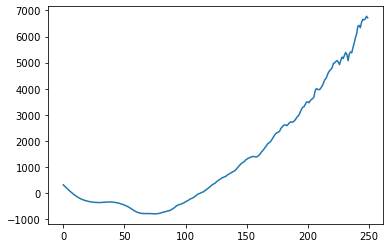

11
Epoch 0/250
3/3 [==============================] - trainLoss: 5.7104  Val_loss: 170.6580 
Epoch 1/250
3/3 [==============================] - trainLoss: 5.4523  Val_loss: 126.8438 
Epoch 2/250
3/3 [==============================] - trainLoss: 5.0668  Val_loss: 84.2035 
Epoch 3/250
3/3 [==============================] - trainLoss: 4.9046  Val_loss: 43.2738 
Epoch 4/250
3/3 [==============================] - trainLoss: 4.5545  Val_loss: 3.9679 
Epoch 5/250
3/3 [==============================] - trainLoss: 4.3358  Val_loss: -33.7766 
Epoch 6/250
3/3 [==============================] - trainLoss: 4.0810  Val_loss: -70.1139 
Epoch 7/250
3/3 [==============================] - trainLoss: 3.8632  Val_loss: -105.2906 
Epoch 8/250
3/3 [==============================] - trainLoss: 3.6653  Val_loss: -138.8012 
Epoch 9/250
3/3 [==============================] - trainLoss: 3.4402  Val_loss: -170.1149 
Epoch 10/250
3/3 [==============================] - trainLoss: 3.2519  Val_loss: -199.2594 
Epoch 

3/3 [==============================] - trainLoss: -2.5014  Val_loss: 229.2334 
Epoch 42/250
3/3 [==============================] - trainLoss: -2.6427  Val_loss: 249.8537 
Epoch 43/250
3/3 [==============================] - trainLoss: -2.7803  Val_loss: 267.0349 
Epoch 44/250
3/3 [==============================] - trainLoss: -2.9678  Val_loss: 277.2614 
Epoch 45/250
3/3 [==============================] - trainLoss: -3.2164  Val_loss: 275.4237 
Epoch 46/250
3/3 [==============================] - trainLoss: -3.3232  Val_loss: 263.5006 
Epoch 47/250
3/3 [==============================] - trainLoss: -3.5524  Val_loss: 248.4988 
Epoch 48/250
3/3 [==============================] - trainLoss: -3.6981  Val_loss: 241.1963 
Epoch 49/250
3/3 [==============================] - trainLoss: -3.8638  Val_loss: 231.2161 
Epoch 50/250
3/3 [==============================] - trainLoss: -4.0142  Val_loss: 220.8933 
Epoch 51/250
3/3 [==============================] - trainLoss: -4.4073  Val_loss: 198.9245 
E

3/3 [==============================] - trainLoss: -19.4310  Val_loss: 5351.3774 
Epoch 218/250
3/3 [==============================] - trainLoss: -19.5723  Val_loss: 5410.3345 
Epoch 219/250
3/3 [==============================] - trainLoss: -19.6453  Val_loss: 5604.1782 
Epoch 220/250
3/3 [==============================] - trainLoss: -19.7819  Val_loss: 5736.6465 
Epoch 221/250
3/3 [==============================] - trainLoss: -19.7246  Val_loss: 5784.9141 
Epoch 222/250
3/3 [==============================] - trainLoss: -19.7900  Val_loss: 5786.9868 
Epoch 223/250
3/3 [==============================] - trainLoss: -20.1511  Val_loss: 5785.5425 
Epoch 224/250
3/3 [==============================] - trainLoss: -19.5720  Val_loss: 5802.4766 
Epoch 225/250
3/3 [==============================] - trainLoss: -19.8030  Val_loss: 5987.2158 
Epoch 226/250
3/3 [==============================] - trainLoss: -19.7530  Val_loss: 6175.1680 
Epoch 227/250
3/3 [==============================] - trainLoss: 

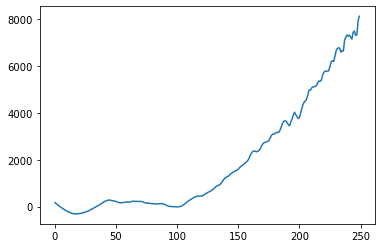

12
Epoch 0/250
3/3 [==============================] - trainLoss: 6.2948  Val_loss: 314.0726 
Epoch 1/250
3/3 [==============================] - trainLoss: 5.8330  Val_loss: 288.1165 
Epoch 2/250
3/3 [==============================] - trainLoss: 5.6355  Val_loss: 265.3760 
Epoch 3/250
3/3 [==============================] - trainLoss: 5.2147  Val_loss: 247.4871 
Epoch 4/250
3/3 [==============================] - trainLoss: 4.9694  Val_loss: 235.3498 
Epoch 5/250
3/3 [==============================] - trainLoss: 4.7010  Val_loss: 228.5445 
Epoch 6/250
3/3 [==============================] - trainLoss: 4.3480  Val_loss: 226.6544 
Epoch 7/250
3/3 [==============================] - trainLoss: 4.1055  Val_loss: 230.1484 
Epoch 8/250
3/3 [==============================] - trainLoss: 3.7431  Val_loss: 238.1667 
Epoch 9/250
3/3 [==============================] - trainLoss: 3.4338  Val_loss: 250.1268 
Epoch 10/250
3/3 [==============================] - trainLoss: 3.3270  Val_loss: 265.0256 
Epoch 

3/3 [==============================] - trainLoss: -4.9516  Val_loss: 24.4129 
Epoch 56/250
3/3 [==============================] - trainLoss: -5.4376  Val_loss: -23.9618 
Epoch 57/250
3/3 [==============================] - trainLoss: -5.1085  Val_loss: -64.6300 
Epoch 58/250
3/3 [==============================] - trainLoss: -5.3820  Val_loss: -106.4696 
Epoch 59/250
3/3 [==============================] - trainLoss: -5.6770  Val_loss: -144.7655 
Epoch 60/250
3/3 [==============================] - trainLoss: -5.8083  Val_loss: -173.4078 
Epoch 61/250
3/3 [==============================] - trainLoss: -6.1528  Val_loss: -204.8827 
Epoch 62/250
3/3 [==============================] - trainLoss: -6.2563  Val_loss: -243.7952 
Epoch 63/250
3/3 [==============================] - trainLoss: -6.2111  Val_loss: -286.0499 
Epoch 64/250
3/3 [==============================] - trainLoss: -6.7516  Val_loss: -328.5122 
Epoch 65/250
3/3 [==============================] - trainLoss: -7.0517  Val_loss: -370.

3/3 [==============================] - trainLoss: -11.1834  Val_loss: -693.8107 
Epoch 87/250
3/3 [==============================] - trainLoss: -11.3299  Val_loss: -701.6754 
Epoch 88/250
3/3 [==============================] - trainLoss: -11.5883  Val_loss: -713.0764 
Epoch 89/250
3/3 [==============================] - trainLoss: -11.9175  Val_loss: -718.0345 
Epoch 90/250
3/3 [==============================] - trainLoss: -11.9813  Val_loss: -719.9339 
Epoch 91/250
3/3 [==============================] - trainLoss: -12.3158  Val_loss: -713.6907 
Epoch 92/250
3/3 [==============================] - trainLoss: -12.2730  Val_loss: -697.5188 
Epoch 93/250
3/3 [==============================] - trainLoss: -12.3426  Val_loss: -679.3373 
Epoch 94/250
3/3 [==============================] - trainLoss: -12.4625  Val_loss: -663.9517 
Epoch 95/250
3/3 [==============================] - trainLoss: -12.8249  Val_loss: -654.0261 
Epoch 96/250
3/3 [==============================] - trainLoss: -13.2488  

3/3 [==============================] - trainLoss: -18.2275  Val_loss: 1786.0237 
Epoch 167/250
3/3 [==============================] - trainLoss: -18.1891  Val_loss: 1847.0248 
Epoch 168/250
3/3 [==============================] - trainLoss: -18.5099  Val_loss: 1912.6515 
Epoch 169/250
3/3 [==============================] - trainLoss: -18.6476  Val_loss: 1998.5685 
Epoch 170/250
3/3 [==============================] - trainLoss: -18.6019  Val_loss: 2088.5859 
Epoch 171/250
3/3 [==============================] - trainLoss: -18.6640  Val_loss: 2150.2302 
Epoch 172/250
3/3 [==============================] - trainLoss: -18.8660  Val_loss: 2239.0557 
Epoch 173/250
3/3 [==============================] - trainLoss: -18.3204  Val_loss: 2315.6184 
Epoch 174/250
3/3 [==============================] - trainLoss: -18.6426  Val_loss: 2318.8445 
Epoch 175/250
3/3 [==============================] - trainLoss: -18.6278  Val_loss: 2378.1238 
Epoch 176/250
3/3 [==============================] - trainLoss: 

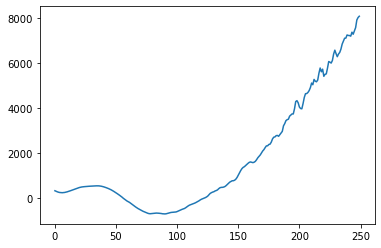

13
Epoch 0/250
3/3 [==============================] - trainLoss: 4.7814  Val_loss: 193.8824 
Epoch 1/250
3/3 [==============================] - trainLoss: 4.5664  Val_loss: 166.3840 
Epoch 2/250
3/3 [==============================] - trainLoss: 4.1617  Val_loss: 141.8531 
Epoch 3/250
3/3 [==============================] - trainLoss: 3.8836  Val_loss: 122.1919 
Epoch 4/250
3/3 [==============================] - trainLoss: 3.6698  Val_loss: 108.0420 
Epoch 5/250
3/3 [==============================] - trainLoss: 3.2668  Val_loss: 99.1844 
Epoch 6/250
3/3 [==============================] - trainLoss: 3.0711  Val_loss: 95.3536 
Epoch 7/250
3/3 [==============================] - trainLoss: 2.7454  Val_loss: 97.5286 
Epoch 8/250
3/3 [==============================] - trainLoss: 2.6367  Val_loss: 104.5322 
Epoch 9/250
3/3 [==============================] - trainLoss: 2.3273  Val_loss: 116.1807 
Epoch 10/250
3/3 [==============================] - trainLoss: 2.1040  Val_loss: 131.7993 
Epoch 11/

3/3 [==============================] - trainLoss: -10.4698  Val_loss: -633.0743 
Epoch 74/250
3/3 [==============================] - trainLoss: -10.5128  Val_loss: -627.7678 
Epoch 75/250
3/3 [==============================] - trainLoss: -10.4365  Val_loss: -605.4299 
Epoch 76/250
3/3 [==============================] - trainLoss: -10.9220  Val_loss: -577.1678 
Epoch 77/250
3/3 [==============================] - trainLoss: -11.2270  Val_loss: -551.1081 
Epoch 78/250
3/3 [==============================] - trainLoss: -11.2047  Val_loss: -533.2957 
Epoch 79/250
3/3 [==============================] - trainLoss: -11.4548  Val_loss: -519.1148 
Epoch 80/250
3/3 [==============================] - trainLoss: -11.6047  Val_loss: -519.3831 
Epoch 81/250
3/3 [==============================] - trainLoss: -11.9885  Val_loss: -517.4739 
Epoch 82/250
3/3 [==============================] - trainLoss: -11.8735  Val_loss: -511.0920 
Epoch 83/250
3/3 [==============================] - trainLoss: -12.3264  

3/3 [==============================] - trainLoss: -18.3302  Val_loss: 1837.8599 
Epoch 162/250
3/3 [==============================] - trainLoss: -18.6275  Val_loss: 1881.5465 
Epoch 163/250
3/3 [==============================] - trainLoss: -18.6397  Val_loss: 1929.2625 
Epoch 164/250
3/3 [==============================] - trainLoss: -18.6720  Val_loss: 1958.1127 
Epoch 165/250
3/3 [==============================] - trainLoss: -18.6115  Val_loss: 1952.2200 
Epoch 166/250
3/3 [==============================] - trainLoss: -18.6299  Val_loss: 1965.4390 
Epoch 167/250
3/3 [==============================] - trainLoss: -18.8570  Val_loss: 1943.7924 
Epoch 168/250
3/3 [==============================] - trainLoss: -18.8563  Val_loss: 1978.5988 
Epoch 169/250
3/3 [==============================] - trainLoss: -18.7512  Val_loss: 2053.7551 
Epoch 170/250
3/3 [==============================] - trainLoss: -18.6141  Val_loss: 2115.5408 
Epoch 171/250
3/3 [==============================] - trainLoss: 

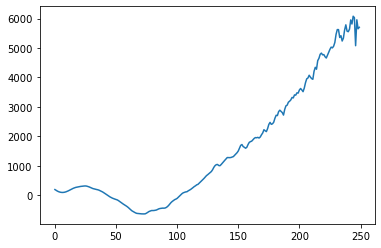

14
Epoch 0/250
3/3 [==============================] - trainLoss: 6.7090  Val_loss: 374.7292 
Epoch 1/250
3/3 [==============================] - trainLoss: 6.4778  Val_loss: 341.7957 
Epoch 2/250
3/3 [==============================] - trainLoss: 6.1663  Val_loss: 310.4722 
Epoch 3/250
3/3 [==============================] - trainLoss: 6.0668  Val_loss: 282.3571 
Epoch 4/250
3/3 [==============================] - trainLoss: 5.5781  Val_loss: 257.2057 
Epoch 5/250
3/3 [==============================] - trainLoss: 5.2324  Val_loss: 235.2820 
Epoch 6/250
3/3 [==============================] - trainLoss: 4.9103  Val_loss: 217.0428 
Epoch 7/250
3/3 [==============================] - trainLoss: 4.7393  Val_loss: 203.0629 
Epoch 8/250
3/3 [==============================] - trainLoss: 4.4158  Val_loss: 193.8671 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.0788  Val_loss: 188.9111 
Epoch 10/250
3/3 [==============================] - trainLoss: 3.9835  Val_loss: 188.0573 
Epoch 

3/3 [==============================] - trainLoss: -4.2634  Val_loss: 182.7889 
Epoch 58/250
3/3 [==============================] - trainLoss: -4.7210  Val_loss: 148.4433 
Epoch 59/250
3/3 [==============================] - trainLoss: -4.8857  Val_loss: 116.4838 
Epoch 60/250
3/3 [==============================] - trainLoss: -5.1086  Val_loss: 84.6888 
Epoch 61/250
3/3 [==============================] - trainLoss: -5.0799  Val_loss: 47.9110 
Epoch 62/250
3/3 [==============================] - trainLoss: -5.3239  Val_loss: 7.1072 
Epoch 63/250
3/3 [==============================] - trainLoss: -5.7356  Val_loss: -37.5247 
Epoch 64/250
3/3 [==============================] - trainLoss: -5.5713  Val_loss: -84.0443 
Epoch 65/250
3/3 [==============================] - trainLoss: -5.7512  Val_loss: -132.0039 
Epoch 66/250
3/3 [==============================] - trainLoss: -6.0366  Val_loss: -175.6138 
Epoch 67/250
3/3 [==============================] - trainLoss: -6.6168  Val_loss: -220.0170 
Ep

3/3 [==============================] - trainLoss: -9.3643  Val_loss: -649.7911 
Epoch 84/250
3/3 [==============================] - trainLoss: -9.4227  Val_loss: -646.4774 
Epoch 85/250
3/3 [==============================] - trainLoss: -9.9456  Val_loss: -641.6097 
Epoch 86/250
3/3 [==============================] - trainLoss: -10.2426  Val_loss: -643.1546 
Epoch 87/250
3/3 [==============================] - trainLoss: -10.3234  Val_loss: -656.4833 
Epoch 88/250
3/3 [==============================] - trainLoss: -10.5133  Val_loss: -668.4649 
Epoch 89/250
3/3 [==============================] - trainLoss: -10.6139  Val_loss: -679.6761 
Epoch 90/250
3/3 [==============================] - trainLoss: -10.8410  Val_loss: -698.3437 
Epoch 91/250
3/3 [==============================] - trainLoss: -11.1574  Val_loss: -707.0972 
Epoch 92/250
3/3 [==============================] - trainLoss: -11.0456  Val_loss: -713.0332 
Epoch 93/250
3/3 [==============================] - trainLoss: -11.4903  Val

3/3 [==============================] - trainLoss: -17.5372  Val_loss: 676.9838 
Epoch 152/250
3/3 [==============================] - trainLoss: -17.7954  Val_loss: 684.4672 
Epoch 153/250
3/3 [==============================] - trainLoss: -17.8017  Val_loss: 682.3619 
Epoch 154/250
3/3 [==============================] - trainLoss: -17.7539  Val_loss: 696.1741 
Epoch 155/250
3/3 [==============================] - trainLoss: -17.9155  Val_loss: 718.7194 
Epoch 156/250
3/3 [==============================] - trainLoss: -17.5707  Val_loss: 754.2877 
Epoch 157/250
3/3 [==============================] - trainLoss: -17.8583  Val_loss: 792.1368 
Epoch 158/250
3/3 [==============================] - trainLoss: -17.8002  Val_loss: 829.8074 
Epoch 159/250
3/3 [==============================] - trainLoss: -17.9163  Val_loss: 886.3362 
Epoch 160/250
3/3 [==============================] - trainLoss: -18.1463  Val_loss: 931.9575 
Epoch 161/250
3/3 [==============================] - trainLoss: -17.8089  

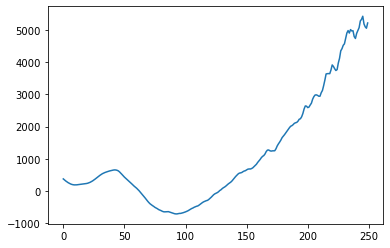

In [3]:
test_loglik_list = []
val_loglik_list = []

for i in range(15):
    
    print(i)


    x_in = keras.layers.Input(shape=[None,num_dims])
    x_out = keras.layers.Input(shape=[None,num_dims])

    hidden_state_in = keras.layers.Input(shape=[hidden_state_size])
    hidden_state_in_2 = keras.layers.Input(shape=[hidden_state_size])

    output2,state = keras.layers.GRU(hidden_state_size,return_sequences=True,return_state=True)(inputs=x_in,initial_state=hidden_state_in)

    hidden_model = keras.models.Model(inputs=[x_in,x_out,hidden_state_in],outputs=[output2,state])

    x_in = keras.layers.Input(shape=[None,num_dims])
    x_out = keras.layers.Input(shape=[None,num_dims])
    hr_out = keras.layers.Input(shape=[None,num_dims_hr])
    hr_in = keras.layers.Input(shape=[None,num_dims_hr])

    hidden_state_in = keras.layers.Input(shape=[hidden_state_size])

    output2,state= hidden_model([x_in,x_out,hidden_state_in])

    layer_hr = keras.layers.Dropout(0.3)(output2)
    layer_hr = keras.layers.Dense(4,activation="elu")(layer_hr)
    layer_hr = keras.layers.Dropout(0.3)(layer_hr)
    final_hr_mean = keras.layers.TimeDistributed(keras.layers.Dense(num_dims_hr,bias_initializer='zeros'))(layer_hr) + hr_in
    sigma_mle_hr = (K.mean((final_hr_mean- hr_out)**2))**0.5

    loglik_hr = loglik_gaussian_hr(hr_out,final_hr_mean,sigma_mle_hr)

    nloglik_hr = loss(loglik_hr)

    rnn_training_hr = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[nloglik_hr])
    rnn_generate_hr = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[final_hr_mean,sigma_mle_hr,state])

    x_in = keras.layers.Input(shape=[None,num_dims])
    x_out = keras.layers.Input(shape=[None,num_dims])
    hr_out = keras.layers.Input(shape=[None,num_dims_hr])
    hr_in = keras.layers.Input(shape=[None,num_dims_hr])

    hidden_state_in = keras.layers.Input(shape=[hidden_state_size])

    output2,state = hidden_model([x_in,x_out,hidden_state_in],training=False)

    layer = keras.layers.Dropout(0.3)(output2)
    layer = keras.layers.Dense(32,activation="elu")(layer)
    layer = keras.layers.Dropout(0.3)(layer)
    final_x_mean = keras.layers.TimeDistributed(keras.layers.Dense(num_dims,bias_initializer='zeros'))(layer) + x_in #this means we predict the residuals (better for learning)
    sigma_mle_x = (K.mean((final_x_mean- x_out)**2))**0.5

    loglik_x = loglik_gaussian_x(x_out,final_x_mean,sigma_mle_x)

    nloglikx = loss(loglik_x)

    rnn_training_x = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[nloglikx])
    rnn_generate_x = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[final_x_mean,sigma_mle_x,state])
    
    @tf.function
    def train_step(inputs,model):
        """Decorated train_step function which applies a gradient update to the parameters"""
        with tf.GradientTape() as tape:
            loss = model(inputs,training=True)
            loss = tf.add_n([loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    optimizer=keras.optimizers.Adam(learning_rate=0.001)

    def fit_model(input_list,epochs,model,simulator,history,validation_loss
                  ,valid_list,hr_toggle,index,batch_size=32):

        start = time.time()
        K.clear_session()

        batch_loss = []
        batches_per_epoch = int(np.ceil(input_list[0].shape[0]/batch_size))
        
        rnn_generate_x.save("no_tl_models/{}.h5".format(index))
        
        for epoch in range(epochs):
                print("Epoch {}/{}".format(epoch,epochs))
                for i in range(batches_per_epoch):
                    batch_list= create_batch(
                        input_list,batch_size)
                    loss = train_step(batch_list,model)
                    batch_loss.append(loss)
                    average_batch_loss = list_average(batch_loss)
                    print_status_bar(i*batch_size,input_list[0].shape[0],average_batch_loss)

                training_loss_for_epoch = list_average(batch_loss)
                batch_loss = []
                history.append(training_loss_for_epoch)

                sigma_mle = simulator(input_list)[1]

                val_loss = valid_loss(valid_list,simulator=simulator,sigma_x = sigma_mle,hr=hr_toggle)

                validation_loss.append(val_loss)
                if val_loss == min(validation_loss):
                    rnn_generate_x.save("no_tl_models/{}.h5".format(index))

                print_status_bar_epoch(input_list[0].shape[0]
                                 ,input_list[0].shape[0],training_loss_for_epoch,val_loss )

        done = time.time()
        elapsed = done-start
        
        plt.plot(validation_loss,label="validation")
        plt.show()
        
    training_losses = []
    validation_losses = []
    
    fit_model(input_list,250,rnn_training_x,rnn_generate_x,training_losses,validation_losses
              ,valid_list,hr_toggle=False,index=i,batch_size=32)
  

    rnn_generate_x = keras.models.load_model("no_tl_models/{}.h5".format(i))
    
    sigma_x = rnn_generate_x(input_list)[1]
    mean = rnn_generate_x(test_list)[0]
    loglik = np.mean(loglik_gaussian_x(test_nn_output,mean,sigma_x))

    test_loglik_list.append(loglik)
    
    mean = rnn_generate_x(valid_list)[0]
    loglik = np.mean(loglik_gaussian_x(valid_nn_output,mean,sigma_x))

    val_loglik_list.append(loglik)
    
a = np.array(test_loglik_list)
b = np.array(val_loglik_list)
array_loglik = np.stack([b,a],axis=1)
np.save("no_tl_models/loglik_array.npy",array_loglik)


In [4]:
array_loglik

array([[ 6.1125250e+02,  1.4962800e+05],
       [ 4.5046561e+02,  1.1471825e+05],
       [ 4.4203448e+02,  9.7900656e+04],
       [ 4.1653018e+02,  1.0205960e+05],
       [ 6.0327838e+02,  1.6197312e+05],
       [ 5.6940546e+02,  1.4877391e+05],
       [-3.6856369e+01, -3.1642672e+04],
       [ 4.3022794e+02,  1.0686517e+05],
       [ 5.6151501e+02,  1.5025286e+05],
       [ 5.5933221e+02,  1.4315812e+05],
       [ 7.8881061e+02,  2.0360939e+05],
       [ 3.1232574e+02,  8.3832391e+04],
       [ 7.1993390e+02,  1.9035989e+05],
       [ 6.3307428e+02,  1.5072659e+05],
       [ 7.1383063e+02,  1.9509494e+05]], dtype=float32)

# TL

0
Epoch 0/20
3/3 [==============================] - trainLoss: 20.4662  Val_loss: 1735.7919 
Epoch 1/20
3/3 [==============================] - trainLoss: 15.3219  Val_loss: 1659.5330 
Epoch 2/20
3/3 [==============================] - trainLoss: 14.5346  Val_loss: 1591.0112 
Epoch 3/20
3/3 [==============================] - trainLoss: 10.9963  Val_loss: 1528.0675 
Epoch 4/20
3/3 [==============================] - trainLoss: 12.5585  Val_loss: 1470.8325 
Epoch 5/20
3/3 [==============================] - trainLoss: 13.5788  Val_loss: 1418.4138 
Epoch 6/20
3/3 [==============================] - trainLoss: 12.6236  Val_loss: 1369.9962 
Epoch 7/20
3/3 [==============================] - trainLoss: 6.0038  Val_loss: 1325.1519 
Epoch 8/20
3/3 [==============================] - trainLoss: 8.8109  Val_loss: 1284.5260 
Epoch 9/20
3/3 [==============================] - trainLoss: 5.2842  Val_loss: 1246.8789 
Epoch 10/20
3/3 [==============================] - trainLoss: 7.5150  Val_loss: 1212.4552 


3/3 [==============================] - trainLoss: 4.8909  Val_loss: 373.2900 
Epoch 5/250
3/3 [==============================] - trainLoss: 4.9543  Val_loss: 354.0420 
Epoch 6/250
3/3 [==============================] - trainLoss: 4.5211  Val_loss: 335.1006 
Epoch 7/250
3/3 [==============================] - trainLoss: 4.5058  Val_loss: 316.4705 
Epoch 8/250
3/3 [==============================] - trainLoss: 4.4582  Val_loss: 298.2339 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.3194  Val_loss: 280.2433 
Epoch 10/250
3/3 [==============================] - trainLoss: 4.0956  Val_loss: 262.5643 
Epoch 11/250
3/3 [==============================] - trainLoss: 4.0567  Val_loss: 245.2078 
Epoch 12/250
3/3 [==============================] - trainLoss: 3.8763  Val_loss: 228.4467 
Epoch 13/250
3/3 [==============================] - trainLoss: 3.6984  Val_loss: 212.1256 
Epoch 14/250
3/3 [==============================] - trainLoss: 3.5496  Val_loss: 196.0482 
Epoch 15/250
3/3 

3/3 [==============================] - trainLoss: 1.9219  Val_loss: -13.9734 
Epoch 31/250
3/3 [==============================] - trainLoss: 1.6742  Val_loss: -23.0405 
Epoch 32/250
3/3 [==============================] - trainLoss: 1.6411  Val_loss: -31.6890 
Epoch 33/250
3/3 [==============================] - trainLoss: 1.6761  Val_loss: -39.3719 
Epoch 34/250
3/3 [==============================] - trainLoss: 1.6952  Val_loss: -46.5334 
Epoch 35/250
3/3 [==============================] - trainLoss: 1.4788  Val_loss: -53.0835 
Epoch 36/250
3/3 [==============================] - trainLoss: 1.3902  Val_loss: -58.8778 
Epoch 37/250
3/3 [==============================] - trainLoss: 1.1725  Val_loss: -64.0023 
Epoch 38/250
3/3 [==============================] - trainLoss: 1.2432  Val_loss: -68.6854 
Epoch 39/250
3/3 [==============================] - trainLoss: 1.1657  Val_loss: -72.7476 
Epoch 40/250
3/3 [==============================] - trainLoss: 1.0280  Val_loss: -75.9093 
Epoch 41/250

3/3 [==============================] - trainLoss: -2.9781  Val_loss: -549.5901 
Epoch 82/250
3/3 [==============================] - trainLoss: -3.1023  Val_loss: -566.1398 
Epoch 83/250
3/3 [==============================] - trainLoss: -3.4357  Val_loss: -584.8955 
Epoch 84/250
3/3 [==============================] - trainLoss: -3.4317  Val_loss: -604.4411 
Epoch 85/250
3/3 [==============================] - trainLoss: -3.6272  Val_loss: -625.3472 
Epoch 86/250
3/3 [==============================] - trainLoss: -3.6550  Val_loss: -646.8920 
Epoch 87/250
3/3 [==============================] - trainLoss: -3.7420  Val_loss: -666.0338 
Epoch 88/250
3/3 [==============================] - trainLoss: -3.8579  Val_loss: -685.7236 
Epoch 89/250
3/3 [==============================] - trainLoss: -3.9205  Val_loss: -707.3654 
Epoch 90/250
3/3 [==============================] - trainLoss: -4.1611  Val_loss: -724.4132 
Epoch 91/250
3/3 [==============================] - trainLoss: -4.0772  Val_loss: -

3/3 [==============================] - trainLoss: -6.0517  Val_loss: -942.4310 
Epoch 108/250
3/3 [==============================] - trainLoss: -6.3769  Val_loss: -948.8222 
Epoch 109/250
3/3 [==============================] - trainLoss: -6.5233  Val_loss: -958.3117 
Epoch 110/250
3/3 [==============================] - trainLoss: -6.5762  Val_loss: -966.9951 
Epoch 111/250
3/3 [==============================] - trainLoss: -6.6164  Val_loss: -976.0902 
Epoch 112/250
3/3 [==============================] - trainLoss: -6.6092  Val_loss: -987.8892 
Epoch 113/250
3/3 [==============================] - trainLoss: -6.7510  Val_loss: -1003.0612 
Epoch 114/250
3/3 [==============================] - trainLoss: -6.9860  Val_loss: -1018.9806 
Epoch 115/250
3/3 [==============================] - trainLoss: -7.0438  Val_loss: -1031.2250 
Epoch 116/250
3/3 [==============================] - trainLoss: -7.0730  Val_loss: -1039.0173 
Epoch 117/250
3/3 [==============================] - trainLoss: -7.327

3/3 [==============================] - trainLoss: -10.1555  Val_loss: -1069.6077 
Epoch 144/250
3/3 [==============================] - trainLoss: -10.1146  Val_loss: -1070.9084 
Epoch 145/250
3/3 [==============================] - trainLoss: -10.3810  Val_loss: -1072.6427 
Epoch 146/250
3/3 [==============================] - trainLoss: -10.4614  Val_loss: -1076.0333 
Epoch 147/250
3/3 [==============================] - trainLoss: -10.4869  Val_loss: -1078.8945 
Epoch 148/250
3/3 [==============================] - trainLoss: -10.6831  Val_loss: -1077.7062 
Epoch 149/250
3/3 [==============================] - trainLoss: -10.6468  Val_loss: -1078.0562 
Epoch 150/250
3/3 [==============================] - trainLoss: -10.9064  Val_loss: -1075.9180 
Epoch 151/250
3/3 [==============================] - trainLoss: -10.8350  Val_loss: -1070.5243 
Epoch 152/250
3/3 [==============================] - trainLoss: -11.2395  Val_loss: -1059.4058 
Epoch 153/250
3/3 [==============================] - t

3/3 [==============================] - trainLoss: -16.3167  Val_loss: -951.3390 
Epoch 228/250
3/3 [==============================] - trainLoss: -16.5530  Val_loss: -957.0209 
Epoch 229/250
3/3 [==============================] - trainLoss: -17.0409  Val_loss: -962.2070 
Epoch 230/250
3/3 [==============================] - trainLoss: -16.9409  Val_loss: -965.7694 
Epoch 231/250
3/3 [==============================] - trainLoss: -16.8551  Val_loss: -965.6576 
Epoch 232/250
3/3 [==============================] - trainLoss: -17.2061  Val_loss: -966.5809 
Epoch 233/250
3/3 [==============================] - trainLoss: -17.0553  Val_loss: -968.7039 
Epoch 234/250
3/3 [==============================] - trainLoss: -16.4346  Val_loss: -966.0191 
Epoch 235/250
3/3 [==============================] - trainLoss: -16.8643  Val_loss: -960.6761 
Epoch 236/250
3/3 [==============================] - trainLoss: -16.7720  Val_loss: -955.1741 
Epoch 237/250
3/3 [==============================] - trainLoss: 

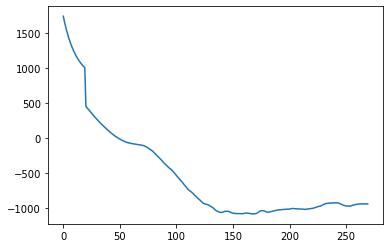

1
Epoch 0/20
3/3 [==============================] - trainLoss: 16.2348  Val_loss: 1767.9241 
Epoch 1/20
3/3 [==============================] - trainLoss: 25.4137  Val_loss: 1701.8232 
Epoch 2/20
3/3 [==============================] - trainLoss: 17.1334  Val_loss: 1640.9104 
Epoch 3/20
3/3 [==============================] - trainLoss: 22.7274  Val_loss: 1585.0801 
Epoch 4/20
3/3 [==============================] - trainLoss: 12.8252  Val_loss: 1534.3506 
Epoch 5/20
3/3 [==============================] - trainLoss: 11.4637  Val_loss: 1488.2660 
Epoch 6/20
3/3 [==============================] - trainLoss: 16.7470  Val_loss: 1446.0259 
Epoch 7/20
3/3 [==============================] - trainLoss: 17.0877  Val_loss: 1407.6578 
Epoch 8/20
3/3 [==============================] - trainLoss: 11.8154  Val_loss: 1372.8137 
Epoch 9/20
3/3 [==============================] - trainLoss: 4.9005  Val_loss: 1341.1162 
Epoch 10/20
3/3 [==============================] - trainLoss: 11.7293  Val_loss: 1311.992

3/3 [==============================] - trainLoss: 5.2338  Val_loss: 404.3773 
Epoch 5/250
3/3 [==============================] - trainLoss: 5.1362  Val_loss: 387.3228 
Epoch 6/250
3/3 [==============================] - trainLoss: 5.0199  Val_loss: 370.3206 
Epoch 7/250
3/3 [==============================] - trainLoss: 4.7767  Val_loss: 353.2425 
Epoch 8/250
3/3 [==============================] - trainLoss: 4.7456  Val_loss: 336.4919 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.4246  Val_loss: 319.9845 
Epoch 10/250
3/3 [==============================] - trainLoss: 4.1130  Val_loss: 303.8201 
Epoch 11/250
3/3 [==============================] - trainLoss: 3.9423  Val_loss: 288.0831 
Epoch 12/250
3/3 [==============================] - trainLoss: 4.0225  Val_loss: 272.9191 
Epoch 13/250
3/3 [==============================] - trainLoss: 3.5708  Val_loss: 258.0991 
Epoch 14/250
3/3 [==============================] - trainLoss: 3.4753  Val_loss: 243.6859 
Epoch 15/250
3/3 

3/3 [==============================] - trainLoss: 1.8239  Val_loss: 100.3746 
Epoch 30/250
3/3 [==============================] - trainLoss: 1.7209  Val_loss: 94.2760 
Epoch 31/250
3/3 [==============================] - trainLoss: 1.5316  Val_loss: 87.9764 
Epoch 32/250
3/3 [==============================] - trainLoss: 1.4420  Val_loss: 81.9192 
Epoch 33/250
3/3 [==============================] - trainLoss: 1.5142  Val_loss: 75.6205 
Epoch 34/250
3/3 [==============================] - trainLoss: 1.3879  Val_loss: 69.0506 
Epoch 35/250
3/3 [==============================] - trainLoss: 1.3095  Val_loss: 62.9409 
Epoch 36/250
3/3 [==============================] - trainLoss: 1.1875  Val_loss: 56.5793 
Epoch 37/250
3/3 [==============================] - trainLoss: 0.8485  Val_loss: 49.4425 
Epoch 38/250
3/3 [==============================] - trainLoss: 0.9530  Val_loss: 40.5986 
Epoch 39/250
3/3 [==============================] - trainLoss: 0.9040  Val_loss: 30.2008 
Epoch 40/250
3/3 [====

3/3 [==============================] - trainLoss: -3.5402  Val_loss: -656.4227 
Epoch 81/250
3/3 [==============================] - trainLoss: -3.5493  Val_loss: -666.0242 
Epoch 82/250
3/3 [==============================] - trainLoss: -3.8294  Val_loss: -675.9376 
Epoch 83/250
3/3 [==============================] - trainLoss: -3.9610  Val_loss: -685.2592 
Epoch 84/250
3/3 [==============================] - trainLoss: -3.8730  Val_loss: -695.1063 
Epoch 85/250
3/3 [==============================] - trainLoss: -3.8450  Val_loss: -708.0814 
Epoch 86/250
3/3 [==============================] - trainLoss: -4.1651  Val_loss: -720.8302 
Epoch 87/250
3/3 [==============================] - trainLoss: -4.3101  Val_loss: -736.0739 
Epoch 88/250
3/3 [==============================] - trainLoss: -4.4961  Val_loss: -749.6677 
Epoch 89/250
3/3 [==============================] - trainLoss: -4.4145  Val_loss: -757.8026 
Epoch 90/250
3/3 [==============================] - trainLoss: -4.5897  Val_loss: -

3/3 [==============================] - trainLoss: -6.5737  Val_loss: -848.9755 
Epoch 110/250
3/3 [==============================] - trainLoss: -6.5845  Val_loss: -851.1369 
Epoch 111/250
3/3 [==============================] - trainLoss: -7.0159  Val_loss: -856.9268 
Epoch 112/250
3/3 [==============================] - trainLoss: -6.9379  Val_loss: -862.9136 
Epoch 113/250
3/3 [==============================] - trainLoss: -7.0963  Val_loss: -870.9370 
Epoch 114/250
3/3 [==============================] - trainLoss: -7.2377  Val_loss: -877.3512 
Epoch 115/250
3/3 [==============================] - trainLoss: -7.5390  Val_loss: -881.4741 
Epoch 116/250
3/3 [==============================] - trainLoss: -7.3568  Val_loss: -881.0500 
Epoch 117/250
3/3 [==============================] - trainLoss: -7.6263  Val_loss: -881.8112 
Epoch 118/250
3/3 [==============================] - trainLoss: -7.7745  Val_loss: -887.9558 
Epoch 119/250
3/3 [==============================] - trainLoss: -7.7763  V

3/3 [==============================] - trainLoss: -10.2904  Val_loss: -954.1678 
Epoch 143/250
3/3 [==============================] - trainLoss: -10.1715  Val_loss: -967.9081 
Epoch 144/250
3/3 [==============================] - trainLoss: -10.3636  Val_loss: -975.8788 
Epoch 145/250
3/3 [==============================] - trainLoss: -10.2879  Val_loss: -977.3271 
Epoch 146/250
3/3 [==============================] - trainLoss: -10.8018  Val_loss: -973.8812 
Epoch 147/250
3/3 [==============================] - trainLoss: -10.5816  Val_loss: -966.3402 
Epoch 148/250
3/3 [==============================] - trainLoss: -10.5224  Val_loss: -955.0795 
Epoch 149/250
3/3 [==============================] - trainLoss: -10.8170  Val_loss: -949.4601 
Epoch 150/250
3/3 [==============================] - trainLoss: -10.8969  Val_loss: -946.4440 
Epoch 151/250
3/3 [==============================] - trainLoss: -11.0085  Val_loss: -945.8279 
Epoch 152/250
3/3 [==============================] - trainLoss: 

3/3 [==============================] - trainLoss: -15.2284  Val_loss: -963.2477 
Epoch 200/250
3/3 [==============================] - trainLoss: -14.9923  Val_loss: -957.4344 
Epoch 201/250
3/3 [==============================] - trainLoss: -15.2110  Val_loss: -953.8535 
Epoch 202/250
3/3 [==============================] - trainLoss: -15.3749  Val_loss: -956.0444 
Epoch 203/250
3/3 [==============================] - trainLoss: -15.4402  Val_loss: -966.2082 
Epoch 204/250
3/3 [==============================] - trainLoss: -15.2137  Val_loss: -971.6854 
Epoch 205/250
3/3 [==============================] - trainLoss: -15.5730  Val_loss: -975.4167 
Epoch 206/250
3/3 [==============================] - trainLoss: -15.3212  Val_loss: -976.2753 
Epoch 207/250
3/3 [==============================] - trainLoss: -15.5271  Val_loss: -978.9357 
Epoch 208/250
3/3 [==============================] - trainLoss: -15.3862  Val_loss: -978.9216 
Epoch 209/250
3/3 [==============================] - trainLoss: 

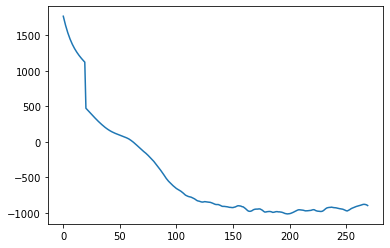

2
Epoch 0/20
3/3 [==============================] - trainLoss: 25.3363  Val_loss: 1994.1321 
Epoch 1/20
3/3 [==============================] - trainLoss: 23.1252  Val_loss: 1900.0382 
Epoch 2/20
3/3 [==============================] - trainLoss: 23.8810  Val_loss: 1812.9309 
Epoch 3/20
3/3 [==============================] - trainLoss: 25.4728  Val_loss: 1733.2876 
Epoch 4/20
3/3 [==============================] - trainLoss: 18.5352  Val_loss: 1661.2588 
Epoch 5/20
3/3 [==============================] - trainLoss: 17.8443  Val_loss: 1595.9686 
Epoch 6/20
3/3 [==============================] - trainLoss: 16.7523  Val_loss: 1536.3037 
Epoch 7/20
3/3 [==============================] - trainLoss: 14.4421  Val_loss: 1481.9137 
Epoch 8/20
3/3 [==============================] - trainLoss: 11.5962  Val_loss: 1432.2032 
Epoch 9/20
3/3 [==============================] - trainLoss: 11.3646  Val_loss: 1386.7566 
Epoch 10/20
3/3 [==============================] - trainLoss: 12.5513  Val_loss: 1345.02

3/3 [==============================] - trainLoss: 5.7186  Val_loss: 335.1594 
Epoch 5/250
3/3 [==============================] - trainLoss: 5.6877  Val_loss: 314.2926 
Epoch 6/250
3/3 [==============================] - trainLoss: 5.2291  Val_loss: 293.1168 
Epoch 7/250
3/3 [==============================] - trainLoss: 4.8692  Val_loss: 271.6930 
Epoch 8/250
3/3 [==============================] - trainLoss: 4.9881  Val_loss: 250.2863 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.6872  Val_loss: 228.7878 
Epoch 10/250
3/3 [==============================] - trainLoss: 4.6838  Val_loss: 207.1932 
Epoch 11/250
3/3 [==============================] - trainLoss: 4.5414  Val_loss: 185.4545 
Epoch 12/250
3/3 [==============================] - trainLoss: 4.2299  Val_loss: 163.8958 
Epoch 13/250
3/3 [==============================] - trainLoss: 4.0127  Val_loss: 142.4099 
Epoch 14/250
3/3 [==============================] - trainLoss: 3.8217  Val_loss: 120.9976 
Epoch 15/250
3/3 

3/3 [==============================] - trainLoss: 1.7958  Val_loss: -113.7804 
Epoch 30/250
3/3 [==============================] - trainLoss: 1.7660  Val_loss: -119.6969 
Epoch 31/250
3/3 [==============================] - trainLoss: 1.6669  Val_loss: -124.2495 
Epoch 32/250
3/3 [==============================] - trainLoss: 1.4174  Val_loss: -128.6774 
Epoch 33/250
3/3 [==============================] - trainLoss: 1.3454  Val_loss: -132.1478 
Epoch 34/250
3/3 [==============================] - trainLoss: 1.2972  Val_loss: -135.0757 
Epoch 35/250
3/3 [==============================] - trainLoss: 1.2396  Val_loss: -138.0910 
Epoch 36/250
3/3 [==============================] - trainLoss: 1.1225  Val_loss: -141.7253 
Epoch 37/250
3/3 [==============================] - trainLoss: 0.9382  Val_loss: -145.6996 
Epoch 38/250
3/3 [==============================] - trainLoss: 0.9663  Val_loss: -150.5117 
Epoch 39/250
3/3 [==============================] - trainLoss: 0.7106  Val_loss: -155.5397 
E

3/3 [==============================] - trainLoss: -3.4165  Val_loss: -721.6955 
Epoch 81/250
3/3 [==============================] - trainLoss: -3.5476  Val_loss: -744.4628 
Epoch 82/250
3/3 [==============================] - trainLoss: -3.5575  Val_loss: -766.9981 
Epoch 83/250
3/3 [==============================] - trainLoss: -3.6774  Val_loss: -790.2659 
Epoch 84/250
3/3 [==============================] - trainLoss: -3.8168  Val_loss: -812.3360 
Epoch 85/250
3/3 [==============================] - trainLoss: -3.9095  Val_loss: -832.2961 
Epoch 86/250
3/3 [==============================] - trainLoss: -4.0612  Val_loss: -851.9843 
Epoch 87/250
3/3 [==============================] - trainLoss: -4.3100  Val_loss: -868.5609 
Epoch 88/250
3/3 [==============================] - trainLoss: -4.4947  Val_loss: -885.3063 
Epoch 89/250
3/3 [==============================] - trainLoss: -4.4595  Val_loss: -903.5219 
Epoch 90/250
3/3 [==============================] - trainLoss: -4.4307  Val_loss: -

3/3 [==============================] - trainLoss: -6.4272  Val_loss: -1151.6525 
Epoch 107/250
3/3 [==============================] - trainLoss: -6.7195  Val_loss: -1159.1141 
Epoch 108/250
3/3 [==============================] - trainLoss: -6.8443  Val_loss: -1165.5417 
Epoch 109/250
3/3 [==============================] - trainLoss: -7.0438  Val_loss: -1173.0665 
Epoch 110/250
3/3 [==============================] - trainLoss: -6.9066  Val_loss: -1182.4066 
Epoch 111/250
3/3 [==============================] - trainLoss: -7.0732  Val_loss: -1191.8817 
Epoch 112/250
3/3 [==============================] - trainLoss: -7.2097  Val_loss: -1202.0753 
Epoch 113/250
3/3 [==============================] - trainLoss: -7.4102  Val_loss: -1210.4614 
Epoch 114/250
3/3 [==============================] - trainLoss: -7.5058  Val_loss: -1219.7660 
Epoch 115/250
3/3 [==============================] - trainLoss: -7.6586  Val_loss: -1229.3456 
Epoch 116/250
3/3 [==============================] - trainLoss: 

3/3 [==============================] - trainLoss: -11.5101  Val_loss: -1222.4432 
Epoch 155/250
3/3 [==============================] - trainLoss: -11.8759  Val_loss: -1228.3895 
Epoch 156/250
3/3 [==============================] - trainLoss: -11.7053  Val_loss: -1234.0349 
Epoch 157/250
3/3 [==============================] - trainLoss: -11.7314  Val_loss: -1239.1023 
Epoch 158/250
3/3 [==============================] - trainLoss: -11.9458  Val_loss: -1242.0845 
Epoch 159/250
3/3 [==============================] - trainLoss: -11.9148  Val_loss: -1239.9412 
Epoch 160/250
3/3 [==============================] - trainLoss: -12.0313  Val_loss: -1236.9579 
Epoch 161/250
3/3 [==============================] - trainLoss: -12.3047  Val_loss: -1235.4727 
Epoch 162/250
3/3 [==============================] - trainLoss: -12.0630  Val_loss: -1234.3203 
Epoch 163/250
3/3 [==============================] - trainLoss: -12.4582  Val_loss: -1230.0710 
Epoch 164/250
3/3 [==============================] - t

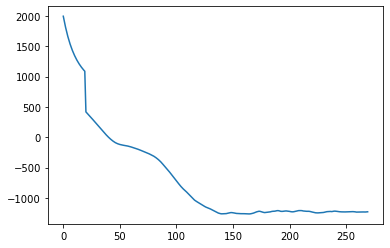

3
Epoch 0/20
3/3 [==============================] - trainLoss: 23.0286  Val_loss: 1354.8324 
Epoch 1/20
3/3 [==============================] - trainLoss: 20.1784  Val_loss: 1299.8423 
Epoch 2/20
3/3 [==============================] - trainLoss: 15.5388  Val_loss: 1253.7336 
Epoch 3/20
3/3 [==============================] - trainLoss: 14.7474  Val_loss: 1214.2494 
Epoch 4/20
3/3 [==============================] - trainLoss: 14.1319  Val_loss: 1179.6061 
Epoch 5/20
3/3 [==============================] - trainLoss: 10.1161  Val_loss: 1149.7137 
Epoch 6/20
3/3 [==============================] - trainLoss: 10.9243  Val_loss: 1123.4622 
Epoch 7/20
3/3 [==============================] - trainLoss: 13.1513  Val_loss: 1099.6947 
Epoch 8/20
3/3 [==============================] - trainLoss: 9.2064  Val_loss: 1078.4037 
Epoch 9/20
3/3 [==============================] - trainLoss: 11.3287  Val_loss: 1058.8544 
Epoch 10/20
3/3 [==============================] - trainLoss: 6.9178  Val_loss: 1040.9581

3/3 [==============================] - trainLoss: 4.8505  Val_loss: 217.5189 
Epoch 5/250
3/3 [==============================] - trainLoss: 4.8284  Val_loss: 204.5125 
Epoch 6/250
3/3 [==============================] - trainLoss: 4.7875  Val_loss: 192.3301 
Epoch 7/250
3/3 [==============================] - trainLoss: 4.2679  Val_loss: 181.0911 
Epoch 8/250
3/3 [==============================] - trainLoss: 4.1548  Val_loss: 170.9238 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.1041  Val_loss: 161.7808 
Epoch 10/250
3/3 [==============================] - trainLoss: 4.1754  Val_loss: 153.6763 
Epoch 11/250
3/3 [==============================] - trainLoss: 3.7654  Val_loss: 146.7430 
Epoch 12/250
3/3 [==============================] - trainLoss: 3.8028  Val_loss: 140.8077 
Epoch 13/250
3/3 [==============================] - trainLoss: 3.6989  Val_loss: 135.7602 
Epoch 14/250
3/3 [==============================] - trainLoss: 3.5670  Val_loss: 131.8019 
Epoch 15/250
3/3 

3/3 [==============================] - trainLoss: 1.9473  Val_loss: 106.0604 
Epoch 30/250
3/3 [==============================] - trainLoss: 1.8094  Val_loss: 102.4130 
Epoch 31/250
3/3 [==============================] - trainLoss: 1.7088  Val_loss: 98.1596 
Epoch 32/250
3/3 [==============================] - trainLoss: 1.6347  Val_loss: 93.8731 
Epoch 33/250
3/3 [==============================] - trainLoss: 1.6399  Val_loss: 89.2445 
Epoch 34/250
3/3 [==============================] - trainLoss: 1.6133  Val_loss: 82.8927 
Epoch 35/250
3/3 [==============================] - trainLoss: 1.5370  Val_loss: 75.8889 
Epoch 36/250
3/3 [==============================] - trainLoss: 1.3660  Val_loss: 67.4637 
Epoch 37/250
3/3 [==============================] - trainLoss: 1.0665  Val_loss: 57.8891 
Epoch 38/250
3/3 [==============================] - trainLoss: 1.1087  Val_loss: 48.3078 
Epoch 39/250
3/3 [==============================] - trainLoss: 1.1624  Val_loss: 37.7050 
Epoch 40/250
3/3 [===

3/3 [==============================] - trainLoss: -3.5396  Val_loss: -776.6840 
Epoch 81/250
3/3 [==============================] - trainLoss: -3.6136  Val_loss: -794.1286 
Epoch 82/250
3/3 [==============================] - trainLoss: -3.3773  Val_loss: -812.6551 
Epoch 83/250
3/3 [==============================] - trainLoss: -3.5319  Val_loss: -829.1646 
Epoch 84/250
3/3 [==============================] - trainLoss: -3.7300  Val_loss: -845.0563 
Epoch 85/250
3/3 [==============================] - trainLoss: -3.6819  Val_loss: -860.2523 
Epoch 86/250
3/3 [==============================] - trainLoss: -4.0500  Val_loss: -875.0650 
Epoch 87/250
3/3 [==============================] - trainLoss: -4.3644  Val_loss: -889.5160 
Epoch 88/250
3/3 [==============================] - trainLoss: -4.3002  Val_loss: -905.3424 
Epoch 89/250
3/3 [==============================] - trainLoss: -4.4927  Val_loss: -921.8658 
Epoch 90/250
3/3 [==============================] - trainLoss: -4.6306  Val_loss: -

3/3 [==============================] - trainLoss: -6.5759  Val_loss: -1063.2559 
Epoch 107/250
3/3 [==============================] - trainLoss: -6.5039  Val_loss: -1060.3193 
Epoch 108/250
3/3 [==============================] - trainLoss: -6.8304  Val_loss: -1056.8157 
Epoch 109/250
3/3 [==============================] - trainLoss: -6.8519  Val_loss: -1054.8304 
Epoch 110/250
3/3 [==============================] - trainLoss: -7.3477  Val_loss: -1058.0095 
Epoch 111/250
3/3 [==============================] - trainLoss: -6.8727  Val_loss: -1059.8943 
Epoch 112/250
3/3 [==============================] - trainLoss: -7.1929  Val_loss: -1058.7838 
Epoch 113/250
3/3 [==============================] - trainLoss: -7.1797  Val_loss: -1057.9120 
Epoch 114/250
3/3 [==============================] - trainLoss: -7.4061  Val_loss: -1058.2028 
Epoch 115/250
3/3 [==============================] - trainLoss: -7.5402  Val_loss: -1056.8217 
Epoch 116/250
3/3 [==============================] - trainLoss: 

3/3 [==============================] - trainLoss: -14.9739  Val_loss: -908.5072 
Epoch 192/250
3/3 [==============================] - trainLoss: -15.2455  Val_loss: -908.5961 
Epoch 193/250
3/3 [==============================] - trainLoss: -15.1931  Val_loss: -913.5674 
Epoch 194/250
3/3 [==============================] - trainLoss: -15.1178  Val_loss: -918.3360 
Epoch 195/250
3/3 [==============================] - trainLoss: -15.3357  Val_loss: -922.5339 
Epoch 196/250
3/3 [==============================] - trainLoss: -15.5506  Val_loss: -923.6964 
Epoch 197/250
3/3 [==============================] - trainLoss: -15.4776  Val_loss: -924.2336 
Epoch 198/250
3/3 [==============================] - trainLoss: -15.4327  Val_loss: -922.6614 
Epoch 199/250
3/3 [==============================] - trainLoss: -15.5509  Val_loss: -917.8176 
Epoch 200/250
3/3 [==============================] - trainLoss: -15.5846  Val_loss: -909.3254 
Epoch 201/250
3/3 [==============================] - trainLoss: 

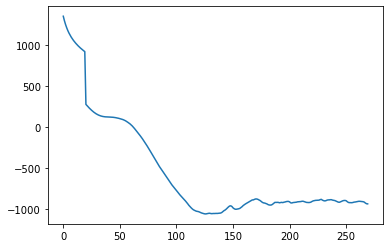

4
Epoch 0/20
3/3 [==============================] - trainLoss: 19.7415  Val_loss: 2183.1025 
Epoch 1/20
3/3 [==============================] - trainLoss: 22.8819  Val_loss: 2091.0427 
Epoch 2/20
3/3 [==============================] - trainLoss: 16.1423  Val_loss: 2005.0979 
Epoch 3/20
3/3 [==============================] - trainLoss: 16.5969  Val_loss: 1923.7389 
Epoch 4/20
3/3 [==============================] - trainLoss: 11.0528  Val_loss: 1848.1399 
Epoch 5/20
3/3 [==============================] - trainLoss: 16.1704  Val_loss: 1777.8124 
Epoch 6/20
3/3 [==============================] - trainLoss: 15.7311  Val_loss: 1712.1176 
Epoch 7/20
3/3 [==============================] - trainLoss: 10.1162  Val_loss: 1651.9209 
Epoch 8/20
3/3 [==============================] - trainLoss: 8.4170  Val_loss: 1596.6659 
Epoch 9/20
3/3 [==============================] - trainLoss: 14.4799  Val_loss: 1545.8270 
Epoch 10/20
3/3 [==============================] - trainLoss: 6.7677  Val_loss: 1499.4731

3/3 [==============================] - trainLoss: 5.7109  Val_loss: 193.4554 
Epoch 5/250
3/3 [==============================] - trainLoss: 5.6607  Val_loss: 171.1614 
Epoch 6/250
3/3 [==============================] - trainLoss: 5.4720  Val_loss: 149.2919 
Epoch 7/250
3/3 [==============================] - trainLoss: 5.2408  Val_loss: 127.8115 
Epoch 8/250
3/3 [==============================] - trainLoss: 5.1704  Val_loss: 107.1020 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.9366  Val_loss: 87.1809 
Epoch 10/250
3/3 [==============================] - trainLoss: 4.8280  Val_loss: 68.4844 
Epoch 11/250
3/3 [==============================] - trainLoss: 4.5913  Val_loss: 50.7663 
Epoch 12/250
3/3 [==============================] - trainLoss: 4.5772  Val_loss: 34.3256 
Epoch 13/250
3/3 [==============================] - trainLoss: 4.5374  Val_loss: 19.4295 
Epoch 14/250
3/3 [==============================] - trainLoss: 4.3368  Val_loss: 5.7390 
Epoch 15/250
3/3 [======

3/3 [==============================] - trainLoss: 1.1841  Val_loss: -57.3660 
Epoch 45/250
3/3 [==============================] - trainLoss: 1.2673  Val_loss: -67.0129 
Epoch 46/250
3/3 [==============================] - trainLoss: 1.0637  Val_loss: -77.1553 
Epoch 47/250
3/3 [==============================] - trainLoss: 0.9844  Val_loss: -86.8351 
Epoch 48/250
3/3 [==============================] - trainLoss: 0.9471  Val_loss: -96.9595 
Epoch 49/250
3/3 [==============================] - trainLoss: 0.8620  Val_loss: -106.6941 
Epoch 50/250
3/3 [==============================] - trainLoss: 0.7144  Val_loss: -114.1544 
Epoch 51/250
3/3 [==============================] - trainLoss: 0.6985  Val_loss: -118.8557 
Epoch 52/250
3/3 [==============================] - trainLoss: 0.3894  Val_loss: -123.0172 
Epoch 53/250
3/3 [==============================] - trainLoss: 0.3014  Val_loss: -128.7340 
Epoch 54/250
3/3 [==============================] - trainLoss: 0.2965  Val_loss: -135.3506 
Epoch 

3/3 [==============================] - trainLoss: -1.2477  Val_loss: -354.4986 
Epoch 70/250
3/3 [==============================] - trainLoss: -1.2816  Val_loss: -380.4603 
Epoch 71/250
3/3 [==============================] - trainLoss: -1.4085  Val_loss: -409.4005 
Epoch 72/250
3/3 [==============================] - trainLoss: -1.5620  Val_loss: -438.4588 
Epoch 73/250
3/3 [==============================] - trainLoss: -1.6774  Val_loss: -467.1172 
Epoch 74/250
3/3 [==============================] - trainLoss: -1.7764  Val_loss: -494.6945 
Epoch 75/250
3/3 [==============================] - trainLoss: -1.8926  Val_loss: -521.8942 
Epoch 76/250
3/3 [==============================] - trainLoss: -2.0430  Val_loss: -549.9667 
Epoch 77/250
3/3 [==============================] - trainLoss: -2.1181  Val_loss: -578.5771 
Epoch 78/250
3/3 [==============================] - trainLoss: -2.1360  Val_loss: -606.8054 
Epoch 79/250
3/3 [==============================] - trainLoss: -2.3876  Val_loss: -

3/3 [==============================] - trainLoss: -4.1096  Val_loss: -1025.6415 
Epoch 96/250
3/3 [==============================] - trainLoss: -4.2020  Val_loss: -1048.6786 
Epoch 97/250
3/3 [==============================] - trainLoss: -4.3365  Val_loss: -1072.3740 
Epoch 98/250
3/3 [==============================] - trainLoss: -4.5278  Val_loss: -1096.2396 
Epoch 99/250
3/3 [==============================] - trainLoss: -4.5116  Val_loss: -1118.6990 
Epoch 100/250
3/3 [==============================] - trainLoss: -4.5744  Val_loss: -1138.8766 
Epoch 101/250
3/3 [==============================] - trainLoss: -4.7689  Val_loss: -1155.5604 
Epoch 102/250
3/3 [==============================] - trainLoss: -4.8781  Val_loss: -1168.0327 
Epoch 103/250
3/3 [==============================] - trainLoss: -4.9618  Val_loss: -1180.1284 
Epoch 104/250
3/3 [==============================] - trainLoss: -5.0789  Val_loss: -1192.4569 
Epoch 105/250
3/3 [==============================] - trainLoss: -5.2

3/3 [==============================] - trainLoss: -7.2758  Val_loss: -1302.5656 
Epoch 127/250
3/3 [==============================] - trainLoss: -7.4927  Val_loss: -1309.4969 
Epoch 128/250
3/3 [==============================] - trainLoss: -7.7304  Val_loss: -1312.8842 
Epoch 129/250
3/3 [==============================] - trainLoss: -7.8030  Val_loss: -1314.5569 
Epoch 130/250
3/3 [==============================] - trainLoss: -7.8124  Val_loss: -1312.0421 
Epoch 131/250
3/3 [==============================] - trainLoss: -7.8615  Val_loss: -1310.7000 
Epoch 132/250
3/3 [==============================] - trainLoss: -8.1013  Val_loss: -1306.5345 
Epoch 133/250
3/3 [==============================] - trainLoss: -8.0715  Val_loss: -1305.0780 
Epoch 134/250
3/3 [==============================] - trainLoss: -8.1072  Val_loss: -1307.4800 
Epoch 135/250
3/3 [==============================] - trainLoss: -8.4528  Val_loss: -1306.8381 
Epoch 136/250
3/3 [==============================] - trainLoss: 

3/3 [==============================] - trainLoss: -14.5585  Val_loss: -1233.5295 
Epoch 206/250
3/3 [==============================] - trainLoss: -14.6070  Val_loss: -1234.5385 
Epoch 207/250
3/3 [==============================] - trainLoss: -14.7067  Val_loss: -1234.1055 
Epoch 208/250
3/3 [==============================] - trainLoss: -14.7963  Val_loss: -1236.8411 
Epoch 209/250
3/3 [==============================] - trainLoss: -14.8310  Val_loss: -1238.7256 
Epoch 210/250
3/3 [==============================] - trainLoss: -14.9331  Val_loss: -1243.1951 
Epoch 211/250
3/3 [==============================] - trainLoss: -14.9745  Val_loss: -1245.8856 
Epoch 212/250
3/3 [==============================] - trainLoss: -15.0239  Val_loss: -1248.0394 
Epoch 213/250
3/3 [==============================] - trainLoss: -15.0334  Val_loss: -1248.3618 
Epoch 214/250
3/3 [==============================] - trainLoss: -14.9294  Val_loss: -1241.3424 
Epoch 215/250
3/3 [==============================] - t

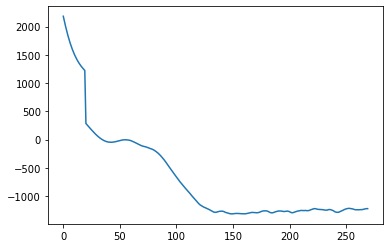

5
Epoch 0/20
3/3 [==============================] - trainLoss: 16.4422  Val_loss: 1784.0992 
Epoch 1/20
3/3 [==============================] - trainLoss: 12.5125  Val_loss: 1710.3818 
Epoch 2/20
3/3 [==============================] - trainLoss: 13.1261  Val_loss: 1642.0206 
Epoch 3/20
3/3 [==============================] - trainLoss: 9.0059  Val_loss: 1580.0151 
Epoch 4/20
3/3 [==============================] - trainLoss: 9.8133  Val_loss: 1523.2820 
Epoch 5/20
3/3 [==============================] - trainLoss: 9.9200  Val_loss: 1470.3120 
Epoch 6/20
3/3 [==============================] - trainLoss: 6.7960  Val_loss: 1422.4482 
Epoch 7/20
3/3 [==============================] - trainLoss: 14.8054  Val_loss: 1376.5303 
Epoch 8/20
3/3 [==============================] - trainLoss: 5.7689  Val_loss: 1333.8927 
Epoch 9/20
3/3 [==============================] - trainLoss: 9.1553  Val_loss: 1293.7581 
Epoch 10/20
3/3 [==============================] - trainLoss: 3.9825  Val_loss: 1256.6613 
Epo

3/3 [==============================] - trainLoss: 5.6593  Val_loss: 170.9956 
Epoch 5/250
3/3 [==============================] - trainLoss: 5.5339  Val_loss: 143.5515 
Epoch 6/250
3/3 [==============================] - trainLoss: 5.4854  Val_loss: 116.3967 
Epoch 7/250
3/3 [==============================] - trainLoss: 5.4058  Val_loss: 89.7596 
Epoch 8/250
3/3 [==============================] - trainLoss: 5.0991  Val_loss: 63.3807 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.9378  Val_loss: 37.4485 
Epoch 10/250
3/3 [==============================] - trainLoss: 4.6466  Val_loss: 12.1632 
Epoch 11/250
3/3 [==============================] - trainLoss: 4.5797  Val_loss: -12.3565 
Epoch 12/250
3/3 [==============================] - trainLoss: 4.3352  Val_loss: -36.1329 
Epoch 13/250
3/3 [==============================] - trainLoss: 4.3136  Val_loss: -59.0796 
Epoch 14/250
3/3 [==============================] - trainLoss: 4.2627  Val_loss: -80.7147 
Epoch 15/250
3/3 [===

3/3 [==============================] - trainLoss: -3.8268  Val_loss: -437.7370 
Epoch 93/250
3/3 [==============================] - trainLoss: -3.9564  Val_loss: -455.7824 
Epoch 94/250
3/3 [==============================] - trainLoss: -4.0302  Val_loss: -474.5741 
Epoch 95/250
3/3 [==============================] - trainLoss: -4.3226  Val_loss: -492.2926 
Epoch 96/250
3/3 [==============================] - trainLoss: -4.3950  Val_loss: -507.6319 
Epoch 97/250
3/3 [==============================] - trainLoss: -4.2763  Val_loss: -521.6987 
Epoch 98/250
3/3 [==============================] - trainLoss: -4.5348  Val_loss: -539.2506 
Epoch 99/250
3/3 [==============================] - trainLoss: -4.6371  Val_loss: -556.2811 
Epoch 100/250
3/3 [==============================] - trainLoss: -4.8480  Val_loss: -569.5580 
Epoch 101/250
3/3 [==============================] - trainLoss: -4.8401  Val_loss: -588.0600 
Epoch 102/250
3/3 [==============================] - trainLoss: -5.0934  Val_loss

3/3 [==============================] - trainLoss: -6.8029  Val_loss: -734.8505 
Epoch 119/250
3/3 [==============================] - trainLoss: -6.8005  Val_loss: -748.8669 
Epoch 120/250
3/3 [==============================] - trainLoss: -6.8381  Val_loss: -766.6901 
Epoch 121/250
3/3 [==============================] - trainLoss: -7.1655  Val_loss: -786.7543 
Epoch 122/250
3/3 [==============================] - trainLoss: -7.1980  Val_loss: -805.7277 
Epoch 123/250
3/3 [==============================] - trainLoss: -7.3307  Val_loss: -823.0562 
Epoch 124/250
3/3 [==============================] - trainLoss: -7.3855  Val_loss: -840.8734 
Epoch 125/250
3/3 [==============================] - trainLoss: -7.3679  Val_loss: -854.2582 
Epoch 126/250
3/3 [==============================] - trainLoss: -7.5002  Val_loss: -865.0143 
Epoch 127/250
3/3 [==============================] - trainLoss: -7.7418  Val_loss: -874.0472 
Epoch 128/250
3/3 [==============================] - trainLoss: -7.8275  V

3/3 [==============================] - trainLoss: -9.7131  Val_loss: -985.9487 
Epoch 147/250
3/3 [==============================] - trainLoss: -9.6664  Val_loss: -984.6630 
Epoch 148/250
3/3 [==============================] - trainLoss: -9.8784  Val_loss: -979.1507 
Epoch 149/250
3/3 [==============================] - trainLoss: -10.0567  Val_loss: -975.1724 
Epoch 150/250
3/3 [==============================] - trainLoss: -10.2312  Val_loss: -972.2120 
Epoch 151/250
3/3 [==============================] - trainLoss: -9.9652  Val_loss: -974.5023 
Epoch 152/250
3/3 [==============================] - trainLoss: -10.2320  Val_loss: -985.4914 
Epoch 153/250
3/3 [==============================] - trainLoss: -10.3190  Val_loss: -993.2216 
Epoch 154/250
3/3 [==============================] - trainLoss: -10.3976  Val_loss: -1003.9896 
Epoch 155/250
3/3 [==============================] - trainLoss: -10.5009  Val_loss: -1009.8779 
Epoch 156/250
3/3 [==============================] - trainLoss: -1

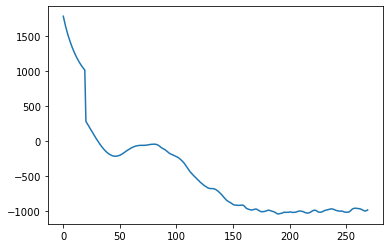

6
Epoch 0/20
3/3 [==============================] - trainLoss: 23.8687  Val_loss: 1781.0693 
Epoch 1/20
3/3 [==============================] - trainLoss: 32.8228  Val_loss: 1680.3275 
Epoch 2/20
3/3 [==============================] - trainLoss: 28.2258  Val_loss: 1591.7032 
Epoch 3/20
3/3 [==============================] - trainLoss: 23.9718  Val_loss: 1511.9686 
Epoch 4/20
3/3 [==============================] - trainLoss: 25.9612  Val_loss: 1440.2854 
Epoch 5/20
3/3 [==============================] - trainLoss: 23.9630  Val_loss: 1376.0271 
Epoch 6/20
3/3 [==============================] - trainLoss: 14.8557  Val_loss: 1319.2523 
Epoch 7/20
3/3 [==============================] - trainLoss: 19.1746  Val_loss: 1269.2253 
Epoch 8/20
3/3 [==============================] - trainLoss: 14.3854  Val_loss: 1226.2742 
Epoch 9/20
3/3 [==============================] - trainLoss: 14.4158  Val_loss: 1188.1857 
Epoch 10/20
3/3 [==============================] - trainLoss: 11.7076  Val_loss: 1154.86

3/3 [==============================] - trainLoss: 5.2709  Val_loss: 290.9452 
Epoch 5/250
3/3 [==============================] - trainLoss: 5.1167  Val_loss: 281.8658 
Epoch 6/250
3/3 [==============================] - trainLoss: 5.0294  Val_loss: 273.4675 
Epoch 7/250
3/3 [==============================] - trainLoss: 4.8821  Val_loss: 265.9201 
Epoch 8/250
3/3 [==============================] - trainLoss: 4.8945  Val_loss: 259.0472 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.5603  Val_loss: 252.9245 
Epoch 10/250
3/3 [==============================] - trainLoss: 4.5884  Val_loss: 247.3015 
Epoch 11/250
3/3 [==============================] - trainLoss: 4.4501  Val_loss: 242.0853 
Epoch 12/250
3/3 [==============================] - trainLoss: 4.1944  Val_loss: 237.5120 
Epoch 13/250
3/3 [==============================] - trainLoss: 4.1004  Val_loss: 233.4254 
Epoch 14/250
3/3 [==============================] - trainLoss: 4.0754  Val_loss: 229.9581 
Epoch 15/250
3/3 

3/3 [==============================] - trainLoss: 0.3530  Val_loss: 266.8995 
Epoch 52/250
3/3 [==============================] - trainLoss: 0.3081  Val_loss: 264.5380 
Epoch 53/250
3/3 [==============================] - trainLoss: 0.1944  Val_loss: 260.1067 
Epoch 54/250
3/3 [==============================] - trainLoss: -0.0314  Val_loss: 254.4915 
Epoch 55/250
3/3 [==============================] - trainLoss: -0.0385  Val_loss: 248.4164 
Epoch 56/250
3/3 [==============================] - trainLoss: -0.1369  Val_loss: 241.6805 
Epoch 57/250
3/3 [==============================] - trainLoss: -0.3608  Val_loss: 235.0035 
Epoch 58/250
3/3 [==============================] - trainLoss: -0.3063  Val_loss: 226.9019 
Epoch 59/250
3/3 [==============================] - trainLoss: -0.5021  Val_loss: 220.2244 
Epoch 60/250
3/3 [==============================] - trainLoss: -0.3473  Val_loss: 210.7090 
Epoch 61/250
3/3 [==============================] - trainLoss: -0.5784  Val_loss: 199.9930 
Epoc

3/3 [==============================] - trainLoss: -2.9729  Val_loss: -138.9792 
Epoch 84/250
3/3 [==============================] - trainLoss: -3.2464  Val_loss: -162.3151 
Epoch 85/250
3/3 [==============================] - trainLoss: -3.1190  Val_loss: -187.0680 
Epoch 86/250
3/3 [==============================] - trainLoss: -3.2742  Val_loss: -214.0555 
Epoch 87/250
3/3 [==============================] - trainLoss: -3.5171  Val_loss: -239.8805 
Epoch 88/250
3/3 [==============================] - trainLoss: -3.6606  Val_loss: -266.0222 
Epoch 89/250
3/3 [==============================] - trainLoss: -3.6481  Val_loss: -286.9742 
Epoch 90/250
3/3 [==============================] - trainLoss: -3.8250  Val_loss: -306.3611 
Epoch 91/250
3/3 [==============================] - trainLoss: -3.8119  Val_loss: -324.5355 
Epoch 92/250
3/3 [==============================] - trainLoss: -4.0117  Val_loss: -347.1983 
Epoch 93/250
3/3 [==============================] - trainLoss: -4.1981  Val_loss: -

3/3 [==============================] - trainLoss: -8.6864  Val_loss: -1104.9742 
Epoch 134/250
3/3 [==============================] - trainLoss: -8.8292  Val_loss: -1110.1392 
Epoch 135/250
3/3 [==============================] - trainLoss: -8.9801  Val_loss: -1108.3918 
Epoch 136/250
3/3 [==============================] - trainLoss: -9.1561  Val_loss: -1110.9819 
Epoch 137/250
3/3 [==============================] - trainLoss: -8.9908  Val_loss: -1115.3265 
Epoch 138/250
3/3 [==============================] - trainLoss: -9.1504  Val_loss: -1123.9923 
Epoch 139/250
3/3 [==============================] - trainLoss: -9.3274  Val_loss: -1129.8821 
Epoch 140/250
3/3 [==============================] - trainLoss: -9.4439  Val_loss: -1135.3613 
Epoch 141/250
3/3 [==============================] - trainLoss: -9.4636  Val_loss: -1144.5181 
Epoch 142/250
3/3 [==============================] - trainLoss: -9.5941  Val_loss: -1150.6884 
Epoch 143/250
3/3 [==============================] - trainLoss: 

3/3 [==============================] - trainLoss: -11.5244  Val_loss: -1202.3959 
Epoch 162/250
3/3 [==============================] - trainLoss: -11.5350  Val_loss: -1201.3051 
Epoch 163/250
3/3 [==============================] - trainLoss: -11.7581  Val_loss: -1202.0664 
Epoch 164/250
3/3 [==============================] - trainLoss: -11.7972  Val_loss: -1202.0686 
Epoch 165/250
3/3 [==============================] - trainLoss: -12.0704  Val_loss: -1199.9969 
Epoch 166/250
3/3 [==============================] - trainLoss: -12.1068  Val_loss: -1202.5106 
Epoch 167/250
3/3 [==============================] - trainLoss: -12.2730  Val_loss: -1209.2479 
Epoch 168/250
3/3 [==============================] - trainLoss: -12.2125  Val_loss: -1215.1484 
Epoch 169/250
3/3 [==============================] - trainLoss: -12.3949  Val_loss: -1219.5852 
Epoch 170/250
3/3 [==============================] - trainLoss: -12.5861  Val_loss: -1219.0057 
Epoch 171/250
3/3 [==============================] - t

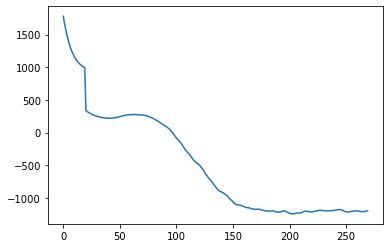

7
Epoch 0/20
3/3 [==============================] - trainLoss: 15.6093  Val_loss: 1368.7538 
Epoch 1/20
3/3 [==============================] - trainLoss: 14.5801  Val_loss: 1312.6638 
Epoch 2/20
3/3 [==============================] - trainLoss: 17.5349  Val_loss: 1262.4592 
Epoch 3/20
3/3 [==============================] - trainLoss: 12.6940  Val_loss: 1217.6755 
Epoch 4/20
3/3 [==============================] - trainLoss: 10.4997  Val_loss: 1177.8420 
Epoch 5/20
3/3 [==============================] - trainLoss: 13.1874  Val_loss: 1142.0824 
Epoch 6/20
3/3 [==============================] - trainLoss: 10.6267  Val_loss: 1109.8961 
Epoch 7/20
3/3 [==============================] - trainLoss: 10.7197  Val_loss: 1081.0609 
Epoch 8/20
3/3 [==============================] - trainLoss: 6.2136  Val_loss: 1055.3710 
Epoch 9/20
3/3 [==============================] - trainLoss: 9.5024  Val_loss: 1032.0992 
Epoch 10/20
3/3 [==============================] - trainLoss: 8.1957  Val_loss: 1011.0394 

3/3 [==============================] - trainLoss: 6.0168  Val_loss: 205.8253 
Epoch 5/250
3/3 [==============================] - trainLoss: 5.7395  Val_loss: 183.3073 
Epoch 6/250
3/3 [==============================] - trainLoss: 5.5396  Val_loss: 161.9262 
Epoch 7/250
3/3 [==============================] - trainLoss: 5.4426  Val_loss: 141.6988 
Epoch 8/250
3/3 [==============================] - trainLoss: 5.2072  Val_loss: 122.7435 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.9913  Val_loss: 105.3775 
Epoch 10/250
3/3 [==============================] - trainLoss: 4.7378  Val_loss: 89.7180 
Epoch 11/250
3/3 [==============================] - trainLoss: 4.5949  Val_loss: 76.0157 
Epoch 12/250
3/3 [==============================] - trainLoss: 4.4835  Val_loss: 64.2261 
Epoch 13/250
3/3 [==============================] - trainLoss: 4.4621  Val_loss: 54.1791 
Epoch 14/250
3/3 [==============================] - trainLoss: 4.2706  Val_loss: 45.6921 
Epoch 15/250
3/3 [====

3/3 [==============================] - trainLoss: -2.3574  Val_loss: -304.9940 
Epoch 82/250
3/3 [==============================] - trainLoss: -2.5167  Val_loss: -336.4216 
Epoch 83/250
3/3 [==============================] - trainLoss: -2.6510  Val_loss: -369.2640 
Epoch 84/250
3/3 [==============================] - trainLoss: -2.8945  Val_loss: -397.1259 
Epoch 85/250
3/3 [==============================] - trainLoss: -2.9740  Val_loss: -423.9124 
Epoch 86/250
3/3 [==============================] - trainLoss: -3.0234  Val_loss: -447.5362 
Epoch 87/250
3/3 [==============================] - trainLoss: -3.1897  Val_loss: -466.8909 
Epoch 88/250
3/3 [==============================] - trainLoss: -3.3470  Val_loss: -485.9287 
Epoch 89/250
3/3 [==============================] - trainLoss: -3.4585  Val_loss: -505.1202 
Epoch 90/250
3/3 [==============================] - trainLoss: -3.3807  Val_loss: -525.0444 
Epoch 91/250
3/3 [==============================] - trainLoss: -3.5808  Val_loss: -

3/3 [==============================] - trainLoss: -5.3575  Val_loss: -862.9554 
Epoch 108/250
3/3 [==============================] - trainLoss: -5.4202  Val_loss: -875.9902 
Epoch 109/250
3/3 [==============================] - trainLoss: -5.5678  Val_loss: -887.6575 
Epoch 110/250
3/3 [==============================] - trainLoss: -5.6794  Val_loss: -898.4979 
Epoch 111/250
3/3 [==============================] - trainLoss: -5.8265  Val_loss: -912.4677 
Epoch 112/250
3/3 [==============================] - trainLoss: -5.8081  Val_loss: -925.7357 
Epoch 113/250
3/3 [==============================] - trainLoss: -6.0592  Val_loss: -941.3824 
Epoch 114/250
3/3 [==============================] - trainLoss: -6.1179  Val_loss: -955.6946 
Epoch 115/250
3/3 [==============================] - trainLoss: -6.2242  Val_loss: -969.6732 
Epoch 116/250
3/3 [==============================] - trainLoss: -6.2877  Val_loss: -985.0604 
Epoch 117/250
3/3 [==============================] - trainLoss: -6.4692  V

3/3 [==============================] - trainLoss: -8.1999  Val_loss: -1146.6484 
Epoch 134/250
3/3 [==============================] - trainLoss: -8.2627  Val_loss: -1155.5780 
Epoch 135/250
3/3 [==============================] - trainLoss: -8.2972  Val_loss: -1168.2863 
Epoch 136/250
3/3 [==============================] - trainLoss: -8.5276  Val_loss: -1180.9858 
Epoch 137/250
3/3 [==============================] - trainLoss: -8.4967  Val_loss: -1190.6768 
Epoch 138/250
3/3 [==============================] - trainLoss: -8.6517  Val_loss: -1197.6984 
Epoch 139/250
3/3 [==============================] - trainLoss: -8.7027  Val_loss: -1205.0336 
Epoch 140/250
3/3 [==============================] - trainLoss: -8.8021  Val_loss: -1213.4413 
Epoch 141/250
3/3 [==============================] - trainLoss: -8.9472  Val_loss: -1218.5629 
Epoch 142/250
3/3 [==============================] - trainLoss: -9.0143  Val_loss: -1218.1394 
Epoch 143/250
3/3 [==============================] - trainLoss: 

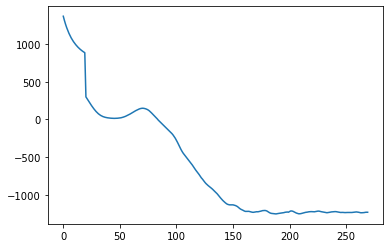

8
Epoch 0/20
3/3 [==============================] - trainLoss: 19.9916  Val_loss: 1924.0405 
Epoch 1/20
3/3 [==============================] - trainLoss: 19.9755  Val_loss: 1829.7354 
Epoch 2/20
3/3 [==============================] - trainLoss: 14.2370  Val_loss: 1744.9476 
Epoch 3/20
3/3 [==============================] - trainLoss: 16.0856  Val_loss: 1668.2195 
Epoch 4/20
3/3 [==============================] - trainLoss: 14.0785  Val_loss: 1598.0112 
Epoch 5/20
3/3 [==============================] - trainLoss: 12.3581  Val_loss: 1533.9786 
Epoch 6/20
3/3 [==============================] - trainLoss: 12.7115  Val_loss: 1475.5488 
Epoch 7/20
3/3 [==============================] - trainLoss: 10.8529  Val_loss: 1422.6115 
Epoch 8/20
3/3 [==============================] - trainLoss: 10.2448  Val_loss: 1374.9401 
Epoch 9/20
3/3 [==============================] - trainLoss: 10.5263  Val_loss: 1331.9181 
Epoch 10/20
3/3 [==============================] - trainLoss: 9.5762  Val_loss: 1293.099

3/3 [==============================] - trainLoss: 5.7875  Val_loss: 174.6636 
Epoch 5/250
3/3 [==============================] - trainLoss: 5.3603  Val_loss: 151.7257 
Epoch 6/250
3/3 [==============================] - trainLoss: 5.2321  Val_loss: 128.8675 
Epoch 7/250
3/3 [==============================] - trainLoss: 4.7857  Val_loss: 106.4579 
Epoch 8/250
3/3 [==============================] - trainLoss: 5.0588  Val_loss: 84.1337 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.7106  Val_loss: 62.3615 
Epoch 10/250
3/3 [==============================] - trainLoss: 4.6259  Val_loss: 40.9559 
Epoch 11/250
3/3 [==============================] - trainLoss: 4.0761  Val_loss: 20.3145 
Epoch 12/250
3/3 [==============================] - trainLoss: 4.1914  Val_loss: 0.3638 
Epoch 13/250
3/3 [==============================] - trainLoss: 3.7300  Val_loss: -18.1711 
Epoch 14/250
3/3 [==============================] - trainLoss: 3.8873  Val_loss: -35.7385 
Epoch 15/250
3/3 [=====

3/3 [==============================] - trainLoss: -1.5481  Val_loss: -307.3580 
Epoch 66/250
3/3 [==============================] - trainLoss: -1.5411  Val_loss: -323.7498 
Epoch 67/250
3/3 [==============================] - trainLoss: -1.6058  Val_loss: -341.6394 
Epoch 68/250
3/3 [==============================] - trainLoss: -1.7325  Val_loss: -358.3069 
Epoch 69/250
3/3 [==============================] - trainLoss: -1.8883  Val_loss: -375.5551 
Epoch 70/250
3/3 [==============================] - trainLoss: -2.0049  Val_loss: -392.5074 
Epoch 71/250
3/3 [==============================] - trainLoss: -1.9125  Val_loss: -408.3734 
Epoch 72/250
3/3 [==============================] - trainLoss: -2.1604  Val_loss: -423.6563 
Epoch 73/250
3/3 [==============================] - trainLoss: -2.2338  Val_loss: -439.6048 
Epoch 74/250
3/3 [==============================] - trainLoss: -2.3879  Val_loss: -455.2086 
Epoch 75/250
3/3 [==============================] - trainLoss: -2.5202  Val_loss: -

3/3 [==============================] - trainLoss: -4.3885  Val_loss: -744.3481 
Epoch 92/250
3/3 [==============================] - trainLoss: -4.4260  Val_loss: -764.8862 
Epoch 93/250
3/3 [==============================] - trainLoss: -4.6637  Val_loss: -786.5382 
Epoch 94/250
3/3 [==============================] - trainLoss: -4.6942  Val_loss: -805.9564 
Epoch 95/250
3/3 [==============================] - trainLoss: -4.6231  Val_loss: -822.6069 
Epoch 96/250
3/3 [==============================] - trainLoss: -5.0931  Val_loss: -835.0153 
Epoch 97/250
3/3 [==============================] - trainLoss: -5.1385  Val_loss: -848.1086 
Epoch 98/250
3/3 [==============================] - trainLoss: -5.1325  Val_loss: -860.0282 
Epoch 99/250
3/3 [==============================] - trainLoss: -5.3348  Val_loss: -870.3353 
Epoch 100/250
3/3 [==============================] - trainLoss: -5.4324  Val_loss: -882.1315 
Epoch 101/250
3/3 [==============================] - trainLoss: -5.3188  Val_loss:

3/3 [==============================] - trainLoss: -10.1373  Val_loss: -1193.2205 
Epoch 148/250
3/3 [==============================] - trainLoss: -10.5900  Val_loss: -1195.6265 
Epoch 149/250
3/3 [==============================] - trainLoss: -10.5120  Val_loss: -1195.2162 
Epoch 150/250
3/3 [==============================] - trainLoss: -10.4781  Val_loss: -1191.9681 
Epoch 151/250
3/3 [==============================] - trainLoss: -10.8662  Val_loss: -1190.5164 
Epoch 152/250
3/3 [==============================] - trainLoss: -10.7948  Val_loss: -1188.8678 
Epoch 153/250
3/3 [==============================] - trainLoss: -10.9282  Val_loss: -1187.3973 
Epoch 154/250
3/3 [==============================] - trainLoss: -10.8342  Val_loss: -1188.0999 
Epoch 155/250
3/3 [==============================] - trainLoss: -11.0768  Val_loss: -1189.0383 
Epoch 156/250
3/3 [==============================] - trainLoss: -11.1811  Val_loss: -1191.8988 
Epoch 157/250
3/3 [==============================] - t

3/3 [==============================] - trainLoss: -14.5221  Val_loss: -1239.1086 
Epoch 195/250
3/3 [==============================] - trainLoss: -14.3035  Val_loss: -1243.9087 
Epoch 196/250
3/3 [==============================] - trainLoss: -14.3435  Val_loss: -1244.3124 
Epoch 197/250
3/3 [==============================] - trainLoss: -14.6086  Val_loss: -1241.3485 
Epoch 198/250
3/3 [==============================] - trainLoss: -14.5184  Val_loss: -1238.1385 
Epoch 199/250
3/3 [==============================] - trainLoss: -14.7006  Val_loss: -1233.9082 
Epoch 200/250
3/3 [==============================] - trainLoss: -14.6034  Val_loss: -1230.6532 
Epoch 201/250
3/3 [==============================] - trainLoss: -14.9040  Val_loss: -1223.8253 
Epoch 202/250
3/3 [==============================] - trainLoss: -14.6662  Val_loss: -1216.1172 
Epoch 203/250
3/3 [==============================] - trainLoss: -15.0161  Val_loss: -1209.2773 
Epoch 204/250
3/3 [==============================] - t

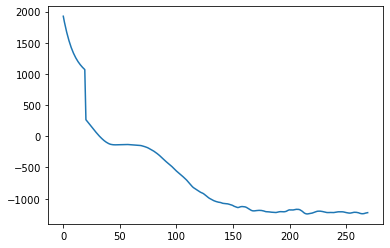

9
Epoch 0/20
3/3 [==============================] - trainLoss: 21.7709  Val_loss: 1422.4623 
Epoch 1/20
3/3 [==============================] - trainLoss: 19.2196  Val_loss: 1368.6160 
Epoch 2/20
3/3 [==============================] - trainLoss: 14.3817  Val_loss: 1320.3232 
Epoch 3/20
3/3 [==============================] - trainLoss: 15.8341  Val_loss: 1276.5669 
Epoch 4/20
3/3 [==============================] - trainLoss: 13.4272  Val_loss: 1237.4978 
Epoch 5/20
3/3 [==============================] - trainLoss: 11.6925  Val_loss: 1202.4735 
Epoch 6/20
3/3 [==============================] - trainLoss: 13.4151  Val_loss: 1171.2091 
Epoch 7/20
3/3 [==============================] - trainLoss: 4.8560  Val_loss: 1143.3514 
Epoch 8/20
3/3 [==============================] - trainLoss: 9.8893  Val_loss: 1118.1378 
Epoch 9/20
3/3 [==============================] - trainLoss: 4.7644  Val_loss: 1095.3787 
Epoch 10/20
3/3 [==============================] - trainLoss: 4.7631  Val_loss: 1074.7719 


3/3 [==============================] - trainLoss: 4.9022  Val_loss: 314.0517 
Epoch 5/250
3/3 [==============================] - trainLoss: 4.6338  Val_loss: 292.9551 
Epoch 6/250
3/3 [==============================] - trainLoss: 4.4456  Val_loss: 271.7817 
Epoch 7/250
3/3 [==============================] - trainLoss: 4.2072  Val_loss: 250.6128 
Epoch 8/250
3/3 [==============================] - trainLoss: 3.9545  Val_loss: 229.6933 
Epoch 9/250
3/3 [==============================] - trainLoss: 3.9000  Val_loss: 209.0321 
Epoch 10/250
3/3 [==============================] - trainLoss: 3.7617  Val_loss: 188.2657 
Epoch 11/250
3/3 [==============================] - trainLoss: 3.5479  Val_loss: 167.6618 
Epoch 12/250
3/3 [==============================] - trainLoss: 3.4800  Val_loss: 147.1804 
Epoch 13/250
3/3 [==============================] - trainLoss: 3.1953  Val_loss: 127.0061 
Epoch 14/250
3/3 [==============================] - trainLoss: 3.0858  Val_loss: 107.0055 
Epoch 15/250
3/3 

3/3 [==============================] - trainLoss: 1.2292  Val_loss: -175.9971 
Epoch 30/250
3/3 [==============================] - trainLoss: 1.1296  Val_loss: -193.0228 
Epoch 31/250
3/3 [==============================] - trainLoss: 1.0968  Val_loss: -208.6061 
Epoch 32/250
3/3 [==============================] - trainLoss: 0.9497  Val_loss: -223.2941 
Epoch 33/250
3/3 [==============================] - trainLoss: 0.7822  Val_loss: -236.0950 
Epoch 34/250
3/3 [==============================] - trainLoss: 0.6138  Val_loss: -247.0094 
Epoch 35/250
3/3 [==============================] - trainLoss: 0.6940  Val_loss: -256.0899 
Epoch 36/250
3/3 [==============================] - trainLoss: 0.3979  Val_loss: -262.6906 
Epoch 37/250
3/3 [==============================] - trainLoss: 0.5243  Val_loss: -267.1709 
Epoch 38/250
3/3 [==============================] - trainLoss: 0.1957  Val_loss: -270.2085 
Epoch 39/250
3/3 [==============================] - trainLoss: 0.1015  Val_loss: -269.9075 
E

3/3 [==============================] - trainLoss: -5.1081  Val_loss: -901.0795 
Epoch 93/250
3/3 [==============================] - trainLoss: -5.2939  Val_loss: -908.6548 
Epoch 94/250
3/3 [==============================] - trainLoss: -5.4019  Val_loss: -918.2234 
Epoch 95/250
3/3 [==============================] - trainLoss: -5.6064  Val_loss: -926.1140 
Epoch 96/250
3/3 [==============================] - trainLoss: -5.6821  Val_loss: -934.0437 
Epoch 97/250
3/3 [==============================] - trainLoss: -5.5715  Val_loss: -945.4838 
Epoch 98/250
3/3 [==============================] - trainLoss: -5.8927  Val_loss: -959.2408 
Epoch 99/250
3/3 [==============================] - trainLoss: -5.9971  Val_loss: -972.5572 
Epoch 100/250
3/3 [==============================] - trainLoss: -6.1266  Val_loss: -984.8895 
Epoch 101/250
3/3 [==============================] - trainLoss: -6.2617  Val_loss: -998.2799 
Epoch 102/250
3/3 [==============================] - trainLoss: -6.2429  Val_loss

3/3 [==============================] - trainLoss: -8.2907  Val_loss: -1117.5934 
Epoch 122/250
3/3 [==============================] - trainLoss: -8.4157  Val_loss: -1128.8500 
Epoch 123/250
3/3 [==============================] - trainLoss: -8.4026  Val_loss: -1137.4143 
Epoch 124/250
3/3 [==============================] - trainLoss: -8.5890  Val_loss: -1137.3116 
Epoch 125/250
3/3 [==============================] - trainLoss: -8.8011  Val_loss: -1132.1915 
Epoch 126/250
3/3 [==============================] - trainLoss: -8.9663  Val_loss: -1125.2350 
Epoch 127/250
3/3 [==============================] - trainLoss: -8.9251  Val_loss: -1115.3557 
Epoch 128/250
3/3 [==============================] - trainLoss: -8.9911  Val_loss: -1111.2880 
Epoch 129/250
3/3 [==============================] - trainLoss: -9.0533  Val_loss: -1108.5450 
Epoch 130/250
3/3 [==============================] - trainLoss: -9.2845  Val_loss: -1103.9309 
Epoch 131/250
3/3 [==============================] - trainLoss: 

3/3 [==============================] - trainLoss: -15.5068  Val_loss: -1020.1862 
Epoch 203/250
3/3 [==============================] - trainLoss: -15.4299  Val_loss: -1018.4625 
Epoch 204/250
3/3 [==============================] - trainLoss: -15.5501  Val_loss: -1016.7904 
Epoch 205/250
3/3 [==============================] - trainLoss: -15.6964  Val_loss: -1013.1328 
Epoch 206/250
3/3 [==============================] - trainLoss: -15.6383  Val_loss: -1005.0140 
Epoch 207/250
3/3 [==============================] - trainLoss: -15.6851  Val_loss: -994.0070 
Epoch 208/250
3/3 [==============================] - trainLoss: -15.8141  Val_loss: -985.1858 
Epoch 209/250
3/3 [==============================] - trainLoss: -15.8678  Val_loss: -978.6832 
Epoch 210/250
3/3 [==============================] - trainLoss: -15.8206  Val_loss: -975.7013 
Epoch 211/250
3/3 [==============================] - trainLoss: -16.0189  Val_loss: -975.7673 
Epoch 212/250
3/3 [==============================] - trainL

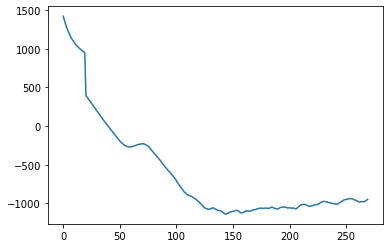

10
Epoch 0/20
3/3 [==============================] - trainLoss: 21.2925  Val_loss: 1469.1664 
Epoch 1/20
3/3 [==============================] - trainLoss: 16.7058  Val_loss: 1421.2510 
Epoch 2/20
3/3 [==============================] - trainLoss: 13.2684  Val_loss: 1377.6812 
Epoch 3/20
3/3 [==============================] - trainLoss: 11.2230  Val_loss: 1337.5317 
Epoch 4/20
3/3 [==============================] - trainLoss: 11.8687  Val_loss: 1300.8831 
Epoch 5/20
3/3 [==============================] - trainLoss: 15.8609  Val_loss: 1267.2002 
Epoch 6/20
3/3 [==============================] - trainLoss: 9.8676  Val_loss: 1235.7863 
Epoch 7/20
3/3 [==============================] - trainLoss: 6.8711  Val_loss: 1206.6968 
Epoch 8/20
3/3 [==============================] - trainLoss: 10.5469  Val_loss: 1179.5717 
Epoch 9/20
3/3 [==============================] - trainLoss: 8.8122  Val_loss: 1154.2480 
Epoch 10/20
3/3 [==============================] - trainLoss: 9.8207  Val_loss: 1130.5349 

3/3 [==============================] - trainLoss: 5.6904  Val_loss: 296.7701 
Epoch 5/250
3/3 [==============================] - trainLoss: 5.4422  Val_loss: 285.3966 
Epoch 6/250
3/3 [==============================] - trainLoss: 5.3168  Val_loss: 275.3491 
Epoch 7/250
3/3 [==============================] - trainLoss: 5.3911  Val_loss: 267.0938 
Epoch 8/250
3/3 [==============================] - trainLoss: 5.0384  Val_loss: 259.8110 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.9875  Val_loss: 253.6315 
Epoch 10/250
3/3 [==============================] - trainLoss: 4.8238  Val_loss: 248.7065 
Epoch 11/250
3/3 [==============================] - trainLoss: 4.7420  Val_loss: 245.1105 
Epoch 12/250
3/3 [==============================] - trainLoss: 4.6040  Val_loss: 243.2970 
Epoch 13/250
3/3 [==============================] - trainLoss: 4.3898  Val_loss: 242.7404 
Epoch 14/250
3/3 [==============================] - trainLoss: 4.3217  Val_loss: 243.5306 
Epoch 15/250
3/3 

3/3 [==============================] - trainLoss: -1.1760  Val_loss: 531.4077 
Epoch 70/250
3/3 [==============================] - trainLoss: -1.2624  Val_loss: 508.6044 
Epoch 71/250
3/3 [==============================] - trainLoss: -1.4504  Val_loss: 480.5084 
Epoch 72/250
3/3 [==============================] - trainLoss: -1.5378  Val_loss: 452.6415 
Epoch 73/250
3/3 [==============================] - trainLoss: -1.6952  Val_loss: 420.0632 
Epoch 74/250
3/3 [==============================] - trainLoss: -1.8070  Val_loss: 388.1042 
Epoch 75/250
3/3 [==============================] - trainLoss: -1.8970  Val_loss: 355.4259 
Epoch 76/250
3/3 [==============================] - trainLoss: -1.9966  Val_loss: 323.4242 
Epoch 77/250
3/3 [==============================] - trainLoss: -2.1386  Val_loss: 290.4965 
Epoch 78/250
3/3 [==============================] - trainLoss: -2.1318  Val_loss: 258.2646 
Epoch 79/250
3/3 [==============================] - trainLoss: -2.2542  Val_loss: 227.1092 
E

3/3 [==============================] - trainLoss: -4.7560  Val_loss: -554.8777 
Epoch 102/250
3/3 [==============================] - trainLoss: -4.9363  Val_loss: -592.9164 
Epoch 103/250
3/3 [==============================] - trainLoss: -5.0445  Val_loss: -633.2488 
Epoch 104/250
3/3 [==============================] - trainLoss: -5.1565  Val_loss: -670.8842 
Epoch 105/250
3/3 [==============================] - trainLoss: -5.1863  Val_loss: -702.8674 
Epoch 106/250
3/3 [==============================] - trainLoss: -5.3618  Val_loss: -738.2579 
Epoch 107/250
3/3 [==============================] - trainLoss: -5.5072  Val_loss: -773.4232 
Epoch 108/250
3/3 [==============================] - trainLoss: -5.6195  Val_loss: -806.1186 
Epoch 109/250
3/3 [==============================] - trainLoss: -5.6620  Val_loss: -834.9268 
Epoch 110/250
3/3 [==============================] - trainLoss: -5.7966  Val_loss: -864.0193 
Epoch 111/250
3/3 [==============================] - trainLoss: -6.0490  V

3/3 [==============================] - trainLoss: -7.6560  Val_loss: -1170.9443 
Epoch 128/250
3/3 [==============================] - trainLoss: -7.8483  Val_loss: -1190.0939 
Epoch 129/250
3/3 [==============================] - trainLoss: -8.0043  Val_loss: -1206.9843 
Epoch 130/250
3/3 [==============================] - trainLoss: -8.0152  Val_loss: -1224.9172 
Epoch 131/250
3/3 [==============================] - trainLoss: -8.1332  Val_loss: -1238.8245 
Epoch 132/250
3/3 [==============================] - trainLoss: -8.2560  Val_loss: -1242.6011 
Epoch 133/250
3/3 [==============================] - trainLoss: -8.4230  Val_loss: -1244.5312 
Epoch 134/250
3/3 [==============================] - trainLoss: -8.5038  Val_loss: -1243.5398 
Epoch 135/250
3/3 [==============================] - trainLoss: -8.5522  Val_loss: -1241.2493 
Epoch 136/250
3/3 [==============================] - trainLoss: -8.7089  Val_loss: -1242.1593 
Epoch 137/250
3/3 [==============================] - trainLoss: 

3/3 [==============================] - trainLoss: -13.0855  Val_loss: -1251.1842 
Epoch 180/250
3/3 [==============================] - trainLoss: -13.1119  Val_loss: -1255.1090 
Epoch 181/250
3/3 [==============================] - trainLoss: -13.2991  Val_loss: -1262.8268 
Epoch 182/250
3/3 [==============================] - trainLoss: -13.2958  Val_loss: -1267.4553 
Epoch 183/250
3/3 [==============================] - trainLoss: -13.5146  Val_loss: -1276.9099 
Epoch 184/250
3/3 [==============================] - trainLoss: -13.6008  Val_loss: -1284.8671 
Epoch 185/250
3/3 [==============================] - trainLoss: -13.4856  Val_loss: -1285.4722 
Epoch 186/250
3/3 [==============================] - trainLoss: -13.5401  Val_loss: -1280.0801 
Epoch 187/250
3/3 [==============================] - trainLoss: -13.8838  Val_loss: -1281.3375 
Epoch 188/250
3/3 [==============================] - trainLoss: -13.8368  Val_loss: -1279.9686 
Epoch 189/250
3/3 [==============================] - t

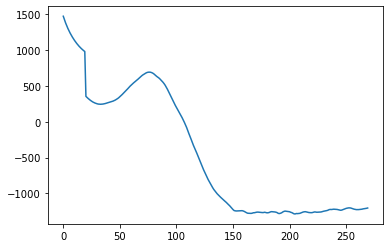

11
Epoch 0/20
3/3 [==============================] - trainLoss: 19.7481  Val_loss: 1626.4095 
Epoch 1/20
3/3 [==============================] - trainLoss: 13.9909  Val_loss: 1553.2727 
Epoch 2/20
3/3 [==============================] - trainLoss: 9.4973  Val_loss: 1487.0134 
Epoch 3/20
3/3 [==============================] - trainLoss: 17.6853  Val_loss: 1426.4901 
Epoch 4/20
3/3 [==============================] - trainLoss: 12.3138  Val_loss: 1371.0243 
Epoch 5/20
3/3 [==============================] - trainLoss: 9.8760  Val_loss: 1320.7321 
Epoch 6/20
3/3 [==============================] - trainLoss: 12.1668  Val_loss: 1275.0852 
Epoch 7/20
3/3 [==============================] - trainLoss: 8.4948  Val_loss: 1233.5767 
Epoch 8/20
3/3 [==============================] - trainLoss: 13.8118  Val_loss: 1195.9713 
Epoch 9/20
3/3 [==============================] - trainLoss: 4.2681  Val_loss: 1161.4149 
Epoch 10/20
3/3 [==============================] - trainLoss: 6.7286  Val_loss: 1129.6599 


3/3 [==============================] - trainLoss: 3.7015  Val_loss: 107.5139 
Epoch 5/250
3/3 [==============================] - trainLoss: 3.5505  Val_loss: 92.8352 
Epoch 6/250
3/3 [==============================] - trainLoss: 3.4614  Val_loss: 79.4105 
Epoch 7/250
3/3 [==============================] - trainLoss: 3.1389  Val_loss: 67.1328 
Epoch 8/250
3/3 [==============================] - trainLoss: 2.9265  Val_loss: 55.9625 
Epoch 9/250
3/3 [==============================] - trainLoss: 2.7315  Val_loss: 46.2277 
Epoch 10/250
3/3 [==============================] - trainLoss: 2.7287  Val_loss: 37.8690 
Epoch 11/250
3/3 [==============================] - trainLoss: 2.5642  Val_loss: 30.9202 
Epoch 12/250
3/3 [==============================] - trainLoss: 2.4765  Val_loss: 25.4730 
Epoch 13/250
3/3 [==============================] - trainLoss: 2.2663  Val_loss: 21.6841 
Epoch 14/250
3/3 [==============================] - trainLoss: 1.9599  Val_loss: 19.3308 
Epoch 15/250
3/3 [=========

3/3 [==============================] - trainLoss: -1.5521  Val_loss: -134.9579 
Epoch 50/250
3/3 [==============================] - trainLoss: -1.7712  Val_loss: -158.1898 
Epoch 51/250
3/3 [==============================] - trainLoss: -1.6519  Val_loss: -181.0544 
Epoch 52/250
3/3 [==============================] - trainLoss: -1.9265  Val_loss: -204.4485 
Epoch 53/250
3/3 [==============================] - trainLoss: -1.9533  Val_loss: -226.8231 
Epoch 54/250
3/3 [==============================] - trainLoss: -2.1170  Val_loss: -250.4011 
Epoch 55/250
3/3 [==============================] - trainLoss: -2.0662  Val_loss: -272.2342 
Epoch 56/250
3/3 [==============================] - trainLoss: -2.3280  Val_loss: -293.6394 
Epoch 57/250
3/3 [==============================] - trainLoss: -2.2094  Val_loss: -314.6395 
Epoch 58/250
3/3 [==============================] - trainLoss: -2.4820  Val_loss: -337.3483 
Epoch 59/250
3/3 [==============================] - trainLoss: -2.6427  Val_loss: -

3/3 [==============================] - trainLoss: -4.2273  Val_loss: -682.5363 
Epoch 76/250
3/3 [==============================] - trainLoss: -4.3338  Val_loss: -704.3036 
Epoch 77/250
3/3 [==============================] - trainLoss: -4.5449  Val_loss: -727.2822 
Epoch 78/250
3/3 [==============================] - trainLoss: -4.6344  Val_loss: -749.7497 
Epoch 79/250
3/3 [==============================] - trainLoss: -4.6610  Val_loss: -773.0789 
Epoch 80/250
3/3 [==============================] - trainLoss: -4.8013  Val_loss: -795.0116 
Epoch 81/250
3/3 [==============================] - trainLoss: -4.9660  Val_loss: -818.0810 
Epoch 82/250
3/3 [==============================] - trainLoss: -5.0476  Val_loss: -840.1564 
Epoch 83/250
3/3 [==============================] - trainLoss: -5.1445  Val_loss: -861.9421 
Epoch 84/250
3/3 [==============================] - trainLoss: -5.4175  Val_loss: -882.7892 
Epoch 85/250
3/3 [==============================] - trainLoss: -5.3279  Val_loss: -

3/3 [==============================] - trainLoss: -10.1570  Val_loss: -1186.2633 
Epoch 132/250
3/3 [==============================] - trainLoss: -10.3118  Val_loss: -1186.1545 
Epoch 133/250
3/3 [==============================] - trainLoss: -10.5963  Val_loss: -1190.6256 
Epoch 134/250
3/3 [==============================] - trainLoss: -10.5514  Val_loss: -1197.7410 
Epoch 135/250
3/3 [==============================] - trainLoss: -10.7015  Val_loss: -1203.9878 
Epoch 136/250
3/3 [==============================] - trainLoss: -10.6403  Val_loss: -1205.8380 
Epoch 137/250
3/3 [==============================] - trainLoss: -10.8625  Val_loss: -1206.6403 
Epoch 138/250
3/3 [==============================] - trainLoss: -10.8828  Val_loss: -1206.0149 
Epoch 139/250
3/3 [==============================] - trainLoss: -11.0481  Val_loss: -1205.4293 
Epoch 140/250
3/3 [==============================] - trainLoss: -11.1377  Val_loss: -1203.7638 
Epoch 141/250
3/3 [==============================] - t

3/3 [==============================] - trainLoss: -15.4128  Val_loss: -1139.6339 
Epoch 198/250
3/3 [==============================] - trainLoss: -15.4892  Val_loss: -1141.3564 
Epoch 199/250
3/3 [==============================] - trainLoss: -15.5596  Val_loss: -1142.2905 
Epoch 200/250
3/3 [==============================] - trainLoss: -15.7214  Val_loss: -1142.4767 
Epoch 201/250
3/3 [==============================] - trainLoss: -15.7199  Val_loss: -1143.5509 
Epoch 202/250
3/3 [==============================] - trainLoss: -15.7271  Val_loss: -1144.4508 
Epoch 203/250
3/3 [==============================] - trainLoss: -16.0074  Val_loss: -1149.6865 
Epoch 204/250
3/3 [==============================] - trainLoss: -16.0093  Val_loss: -1157.0577 
Epoch 205/250
3/3 [==============================] - trainLoss: -15.5943  Val_loss: -1155.7465 
Epoch 206/250
3/3 [==============================] - trainLoss: -15.8882  Val_loss: -1152.3030 
Epoch 207/250
3/3 [==============================] - t

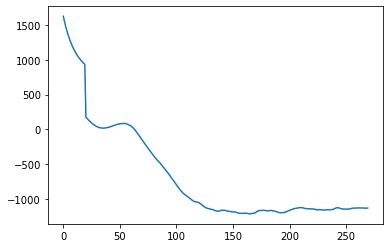

12
Epoch 0/20
3/3 [==============================] - trainLoss: 27.7645  Val_loss: 1964.8560 
Epoch 1/20
3/3 [==============================] - trainLoss: 24.6278  Val_loss: 1865.8590 
Epoch 2/20
3/3 [==============================] - trainLoss: 27.1665  Val_loss: 1777.8582 
Epoch 3/20
3/3 [==============================] - trainLoss: 24.1993  Val_loss: 1699.4003 
Epoch 4/20
3/3 [==============================] - trainLoss: 15.4654  Val_loss: 1628.1401 
Epoch 5/20
3/3 [==============================] - trainLoss: 20.4624  Val_loss: 1564.9915 
Epoch 6/20
3/3 [==============================] - trainLoss: 16.6461  Val_loss: 1508.1580 
Epoch 7/20
3/3 [==============================] - trainLoss: 12.9138  Val_loss: 1457.5435 
Epoch 8/20
3/3 [==============================] - trainLoss: 11.5194  Val_loss: 1412.3098 
Epoch 9/20
3/3 [==============================] - trainLoss: 6.6691  Val_loss: 1371.2333 
Epoch 10/20
3/3 [==============================] - trainLoss: 12.6764  Val_loss: 1335.05

3/3 [==============================] - trainLoss: 5.7823  Val_loss: 248.2833 
Epoch 5/250
3/3 [==============================] - trainLoss: 5.6623  Val_loss: 223.9122 
Epoch 6/250
3/3 [==============================] - trainLoss: 5.3125  Val_loss: 199.4558 
Epoch 7/250
3/3 [==============================] - trainLoss: 5.1784  Val_loss: 175.0372 
Epoch 8/250
3/3 [==============================] - trainLoss: 4.9991  Val_loss: 150.5870 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.8302  Val_loss: 126.2110 
Epoch 10/250
3/3 [==============================] - trainLoss: 4.6717  Val_loss: 102.3625 
Epoch 11/250
3/3 [==============================] - trainLoss: 4.4943  Val_loss: 78.9559 
Epoch 12/250
3/3 [==============================] - trainLoss: 4.4669  Val_loss: 55.8906 
Epoch 13/250
3/3 [==============================] - trainLoss: 4.3557  Val_loss: 33.2515 
Epoch 14/250
3/3 [==============================] - trainLoss: 4.1464  Val_loss: 11.0084 
Epoch 15/250
3/3 [===

3/3 [==============================] - trainLoss: 2.4868  Val_loss: -224.7192 
Epoch 30/250
3/3 [==============================] - trainLoss: 2.3151  Val_loss: -234.3052 
Epoch 31/250
3/3 [==============================] - trainLoss: 2.4322  Val_loss: -243.6942 
Epoch 32/250
3/3 [==============================] - trainLoss: 2.0995  Val_loss: -253.2908 
Epoch 33/250
3/3 [==============================] - trainLoss: 2.0166  Val_loss: -262.8928 
Epoch 34/250
3/3 [==============================] - trainLoss: 2.1075  Val_loss: -273.0391 
Epoch 35/250
3/3 [==============================] - trainLoss: 1.8767  Val_loss: -283.5346 
Epoch 36/250
3/3 [==============================] - trainLoss: 1.7888  Val_loss: -294.0587 
Epoch 37/250
3/3 [==============================] - trainLoss: 1.7858  Val_loss: -304.5162 
Epoch 38/250
3/3 [==============================] - trainLoss: 1.6707  Val_loss: -315.6696 
Epoch 39/250
3/3 [==============================] - trainLoss: 1.4469  Val_loss: -327.7872 
E

3/3 [==============================] - trainLoss: -2.3835  Val_loss: -971.0125 
Epoch 81/250
3/3 [==============================] - trainLoss: -2.5045  Val_loss: -984.3358 
Epoch 82/250
3/3 [==============================] - trainLoss: -2.6686  Val_loss: -993.5439 
Epoch 83/250
3/3 [==============================] - trainLoss: -2.7455  Val_loss: -1003.1671 
Epoch 84/250
3/3 [==============================] - trainLoss: -2.7930  Val_loss: -1011.3430 
Epoch 85/250
3/3 [==============================] - trainLoss: -2.9421  Val_loss: -1016.7492 
Epoch 86/250
3/3 [==============================] - trainLoss: -2.9262  Val_loss: -1019.3363 
Epoch 87/250
3/3 [==============================] - trainLoss: -3.1704  Val_loss: -1023.9554 
Epoch 88/250
3/3 [==============================] - trainLoss: -3.1602  Val_loss: -1029.7760 
Epoch 89/250
3/3 [==============================] - trainLoss: -3.2565  Val_loss: -1040.2013 
Epoch 90/250
3/3 [==============================] - trainLoss: -3.4974  Val_

3/3 [==============================] - trainLoss: -4.9794  Val_loss: -1194.9236 
Epoch 107/250
3/3 [==============================] - trainLoss: -5.2796  Val_loss: -1197.5355 
Epoch 108/250
3/3 [==============================] - trainLoss: -5.4382  Val_loss: -1198.4304 
Epoch 109/250
3/3 [==============================] - trainLoss: -5.5336  Val_loss: -1199.3298 
Epoch 110/250
3/3 [==============================] - trainLoss: -5.5246  Val_loss: -1199.5433 
Epoch 111/250
3/3 [==============================] - trainLoss: -5.7413  Val_loss: -1202.4863 
Epoch 112/250
3/3 [==============================] - trainLoss: -5.7887  Val_loss: -1210.6033 
Epoch 113/250
3/3 [==============================] - trainLoss: -6.0511  Val_loss: -1221.4277 
Epoch 114/250
3/3 [==============================] - trainLoss: -6.0500  Val_loss: -1231.0688 
Epoch 115/250
3/3 [==============================] - trainLoss: -5.8994  Val_loss: -1242.1173 
Epoch 116/250
3/3 [==============================] - trainLoss: 

3/3 [==============================] - trainLoss: -9.2226  Val_loss: -1228.6290 
Epoch 145/250
3/3 [==============================] - trainLoss: -9.4267  Val_loss: -1226.2311 
Epoch 146/250
3/3 [==============================] - trainLoss: -9.0522  Val_loss: -1225.7941 
Epoch 147/250
3/3 [==============================] - trainLoss: -9.5374  Val_loss: -1230.0514 
Epoch 148/250
3/3 [==============================] - trainLoss: -9.3834  Val_loss: -1239.5646 
Epoch 149/250
3/3 [==============================] - trainLoss: -9.8034  Val_loss: -1241.8307 
Epoch 150/250
3/3 [==============================] - trainLoss: -9.7008  Val_loss: -1241.5200 
Epoch 151/250
3/3 [==============================] - trainLoss: -9.9172  Val_loss: -1239.1984 
Epoch 152/250
3/3 [==============================] - trainLoss: -10.1970  Val_loss: -1232.7008 
Epoch 153/250
3/3 [==============================] - trainLoss: -10.1445  Val_loss: -1228.1028 
Epoch 154/250
3/3 [==============================] - trainLoss

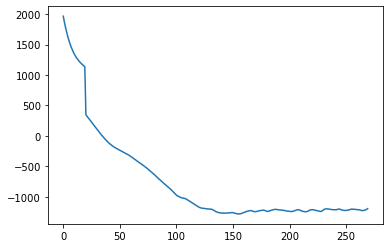

13
Epoch 0/20
3/3 [==============================] - trainLoss: 10.6357  Val_loss: 1612.3353 
Epoch 1/20
3/3 [==============================] - trainLoss: 18.9624  Val_loss: 1547.6978 
Epoch 2/20
3/3 [==============================] - trainLoss: 13.6819  Val_loss: 1488.0917 
Epoch 3/20
3/3 [==============================] - trainLoss: 16.4769  Val_loss: 1432.8298 
Epoch 4/20
3/3 [==============================] - trainLoss: 10.8312  Val_loss: 1382.0470 
Epoch 5/20
3/3 [==============================] - trainLoss: 8.9676  Val_loss: 1335.9153 
Epoch 6/20
3/3 [==============================] - trainLoss: 7.4480  Val_loss: 1293.4813 
Epoch 7/20
3/3 [==============================] - trainLoss: 8.1682  Val_loss: 1254.4458 
Epoch 8/20
3/3 [==============================] - trainLoss: 7.4154  Val_loss: 1218.5427 
Epoch 9/20
3/3 [==============================] - trainLoss: 11.4983  Val_loss: 1185.5280 
Epoch 10/20
3/3 [==============================] - trainLoss: 7.9485  Val_loss: 1155.1157 


3/3 [==============================] - trainLoss: 5.6574  Val_loss: 366.5750 
Epoch 5/250
3/3 [==============================] - trainLoss: 5.4832  Val_loss: 348.6461 
Epoch 6/250
3/3 [==============================] - trainLoss: 5.3825  Val_loss: 331.0149 
Epoch 7/250
3/3 [==============================] - trainLoss: 5.1409  Val_loss: 313.8022 
Epoch 8/250
3/3 [==============================] - trainLoss: 5.0666  Val_loss: 297.0482 
Epoch 9/250
3/3 [==============================] - trainLoss: 4.7798  Val_loss: 280.7650 
Epoch 10/250
3/3 [==============================] - trainLoss: 4.8093  Val_loss: 265.4087 
Epoch 11/250
3/3 [==============================] - trainLoss: 4.5593  Val_loss: 251.1020 
Epoch 12/250
3/3 [==============================] - trainLoss: 4.3998  Val_loss: 237.9144 
Epoch 13/250
3/3 [==============================] - trainLoss: 4.2538  Val_loss: 225.8558 
Epoch 14/250
3/3 [==============================] - trainLoss: 4.0444  Val_loss: 215.0647 
Epoch 15/250
3/3 

3/3 [==============================] - trainLoss: -4.0843  Val_loss: -377.3228 
Epoch 94/250
3/3 [==============================] - trainLoss: -4.2968  Val_loss: -392.9832 
Epoch 95/250
3/3 [==============================] - trainLoss: -4.2303  Val_loss: -412.0422 
Epoch 96/250
3/3 [==============================] - trainLoss: -4.3941  Val_loss: -431.7305 
Epoch 97/250
3/3 [==============================] - trainLoss: -4.5300  Val_loss: -452.6469 
Epoch 98/250
3/3 [==============================] - trainLoss: -4.6530  Val_loss: -472.2345 
Epoch 99/250
3/3 [==============================] - trainLoss: -4.6597  Val_loss: -494.1584 
Epoch 100/250
3/3 [==============================] - trainLoss: -4.8209  Val_loss: -518.1364 
Epoch 101/250
3/3 [==============================] - trainLoss: -4.9790  Val_loss: -536.4828 
Epoch 102/250
3/3 [==============================] - trainLoss: -5.1318  Val_loss: -554.6553 
Epoch 103/250
3/3 [==============================] - trainLoss: -5.1649  Val_los

3/3 [==============================] - trainLoss: -6.9974  Val_loss: -904.9489 
Epoch 120/250
3/3 [==============================] - trainLoss: -7.1137  Val_loss: -921.4415 
Epoch 121/250
3/3 [==============================] - trainLoss: -7.1590  Val_loss: -939.6229 
Epoch 122/250
3/3 [==============================] - trainLoss: -7.3234  Val_loss: -955.0901 
Epoch 123/250
3/3 [==============================] - trainLoss: -7.4542  Val_loss: -971.9957 
Epoch 124/250
3/3 [==============================] - trainLoss: -7.5668  Val_loss: -986.9076 
Epoch 125/250
3/3 [==============================] - trainLoss: -7.6135  Val_loss: -997.8298 
Epoch 126/250
3/3 [==============================] - trainLoss: -7.6683  Val_loss: -1004.4994 
Epoch 127/250
3/3 [==============================] - trainLoss: -7.8871  Val_loss: -1010.4813 
Epoch 128/250
3/3 [==============================] - trainLoss: -7.9554  Val_loss: -1016.5760 
Epoch 129/250
3/3 [==============================] - trainLoss: -8.0168

3/3 [==============================] - trainLoss: -14.9700  Val_loss: -1049.9178 
Epoch 208/250
3/3 [==============================] - trainLoss: -15.0898  Val_loss: -1051.0797 
Epoch 209/250
3/3 [==============================] - trainLoss: -15.2792  Val_loss: -1051.2834 
Epoch 210/250
3/3 [==============================] - trainLoss: -15.4634  Val_loss: -1050.5428 
Epoch 211/250
3/3 [==============================] - trainLoss: -15.2420  Val_loss: -1047.4171 
Epoch 212/250
3/3 [==============================] - trainLoss: -15.3180  Val_loss: -1045.9581 
Epoch 213/250
3/3 [==============================] - trainLoss: -15.3322  Val_loss: -1044.3639 
Epoch 214/250
3/3 [==============================] - trainLoss: -15.5310  Val_loss: -1043.2405 
Epoch 215/250
3/3 [==============================] - trainLoss: -15.5945  Val_loss: -1046.1567 
Epoch 216/250
3/3 [==============================] - trainLoss: -15.4695  Val_loss: -1047.4409 
Epoch 217/250
3/3 [==============================] - t

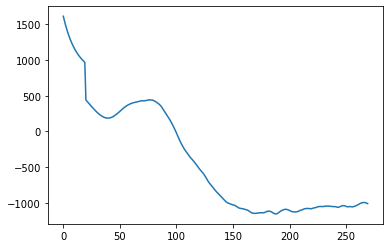

14
Epoch 0/20
3/3 [==============================] - trainLoss: 16.2424  Val_loss: 1268.6930 
Epoch 1/20
3/3 [==============================] - trainLoss: 14.4793  Val_loss: 1220.4148 
Epoch 2/20
3/3 [==============================] - trainLoss: 9.9824  Val_loss: 1177.7056 
Epoch 3/20
3/3 [==============================] - trainLoss: 10.0001  Val_loss: 1140.4762 
Epoch 4/20
3/3 [==============================] - trainLoss: 12.7726  Val_loss: 1107.6852 
Epoch 5/20
3/3 [==============================] - trainLoss: 9.8336  Val_loss: 1079.0803 
Epoch 6/20
3/3 [==============================] - trainLoss: 10.1290  Val_loss: 1054.3380 
Epoch 7/20
3/3 [==============================] - trainLoss: 7.6966  Val_loss: 1032.9121 
Epoch 8/20
3/3 [==============================] - trainLoss: 8.1305  Val_loss: 1014.2080 
Epoch 9/20
3/3 [==============================] - trainLoss: 3.7873  Val_loss: 997.9844 
Epoch 10/20
3/3 [==============================] - trainLoss: 6.3139  Val_loss: 983.8483 
Epo

3/3 [==============================] - trainLoss: 6.5145  Val_loss: 368.3878 
Epoch 5/250
3/3 [==============================] - trainLoss: 6.3812  Val_loss: 352.1385 
Epoch 6/250
3/3 [==============================] - trainLoss: 6.1905  Val_loss: 336.3415 
Epoch 7/250
3/3 [==============================] - trainLoss: 5.9662  Val_loss: 321.1126 
Epoch 8/250
3/3 [==============================] - trainLoss: 5.8280  Val_loss: 306.6962 
Epoch 9/250
3/3 [==============================] - trainLoss: 5.6608  Val_loss: 293.1213 
Epoch 10/250
3/3 [==============================] - trainLoss: 5.5035  Val_loss: 280.6198 
Epoch 11/250
3/3 [==============================] - trainLoss: 5.3430  Val_loss: 269.2897 
Epoch 12/250
3/3 [==============================] - trainLoss: 5.2131  Val_loss: 258.9595 
Epoch 13/250
3/3 [==============================] - trainLoss: 5.1267  Val_loss: 250.6830 
Epoch 14/250
3/3 [==============================] - trainLoss: 4.8506  Val_loss: 243.9591 
Epoch 15/250
3/3 

3/3 [==============================] - trainLoss: -2.7568  Val_loss: -222.0972 
Epoch 88/250
3/3 [==============================] - trainLoss: -2.7692  Val_loss: -248.7778 
Epoch 89/250
3/3 [==============================] - trainLoss: -2.8279  Val_loss: -278.5092 
Epoch 90/250
3/3 [==============================] - trainLoss: -3.0277  Val_loss: -309.1225 
Epoch 91/250
3/3 [==============================] - trainLoss: -3.1903  Val_loss: -338.5294 
Epoch 92/250
3/3 [==============================] - trainLoss: -3.4448  Val_loss: -364.3561 
Epoch 93/250
3/3 [==============================] - trainLoss: -3.4766  Val_loss: -390.2723 
Epoch 94/250
3/3 [==============================] - trainLoss: -3.6486  Val_loss: -417.2048 
Epoch 95/250
3/3 [==============================] - trainLoss: -3.5856  Val_loss: -445.1003 
Epoch 96/250
3/3 [==============================] - trainLoss: -3.7078  Val_loss: -470.6029 
Epoch 97/250
3/3 [==============================] - trainLoss: -3.8544  Val_loss: -

3/3 [==============================] - trainLoss: -5.9847  Val_loss: -913.2519 
Epoch 114/250
3/3 [==============================] - trainLoss: -6.1101  Val_loss: -930.2543 
Epoch 115/250
3/3 [==============================] - trainLoss: -6.2235  Val_loss: -946.7917 
Epoch 116/250
3/3 [==============================] - trainLoss: -6.2595  Val_loss: -962.2510 
Epoch 117/250
3/3 [==============================] - trainLoss: -6.4133  Val_loss: -979.0671 
Epoch 118/250
3/3 [==============================] - trainLoss: -6.5256  Val_loss: -998.4501 
Epoch 119/250
3/3 [==============================] - trainLoss: -6.6362  Val_loss: -1019.2120 
Epoch 120/250
3/3 [==============================] - trainLoss: -6.6950  Val_loss: -1040.9434 
Epoch 121/250
3/3 [==============================] - trainLoss: -6.7767  Val_loss: -1061.5229 
Epoch 122/250
3/3 [==============================] - trainLoss: -6.8691  Val_loss: -1082.4929 
Epoch 123/250
3/3 [==============================] - trainLoss: -7.123

3/3 [==============================] - trainLoss: -13.8232  Val_loss: -1242.5961 
Epoch 188/250
3/3 [==============================] - trainLoss: -13.8532  Val_loss: -1236.9990 
Epoch 189/250
3/3 [==============================] - trainLoss: -13.8997  Val_loss: -1230.7726 
Epoch 190/250
3/3 [==============================] - trainLoss: -14.0730  Val_loss: -1227.1729 
Epoch 191/250
3/3 [==============================] - trainLoss: -14.0991  Val_loss: -1222.8042 
Epoch 192/250
3/3 [==============================] - trainLoss: -14.3603  Val_loss: -1223.7539 
Epoch 193/250
3/3 [==============================] - trainLoss: -14.2912  Val_loss: -1226.2493 
Epoch 194/250
3/3 [==============================] - trainLoss: -14.2394  Val_loss: -1227.8407 
Epoch 195/250
3/3 [==============================] - trainLoss: -14.5011  Val_loss: -1230.2087 
Epoch 196/250
3/3 [==============================] - trainLoss: -14.4463  Val_loss: -1229.7253 
Epoch 197/250
3/3 [==============================] - t

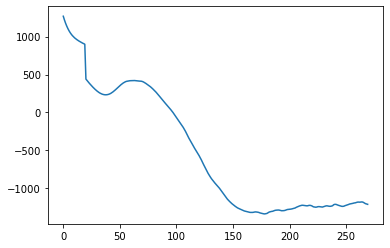

In [5]:
test_loglik_list = []
val_loglik_list = []

for i in range(15):
    
    print(i)


    x_in = keras.layers.Input(shape=[None,num_dims])
    x_out = keras.layers.Input(shape=[None,num_dims])

    hidden_state_in = keras.layers.Input(shape=[hidden_state_size])
    hidden_state_in_2 = keras.layers.Input(shape=[hidden_state_size])

    output2,state = keras.layers.GRU(hidden_state_size,return_sequences=True,return_state=True)(inputs=x_in,initial_state=hidden_state_in)

    hidden_model = keras.models.Model(inputs=[x_in,x_out,hidden_state_in],outputs=[output2,state])

    x_in = keras.layers.Input(shape=[None,num_dims])
    x_out = keras.layers.Input(shape=[None,num_dims])
    hr_out = keras.layers.Input(shape=[None,num_dims_hr])
    hr_in = keras.layers.Input(shape=[None,num_dims_hr])

    hidden_state_in = keras.layers.Input(shape=[hidden_state_size])

    output2,state= hidden_model([x_in,x_out,hidden_state_in])

    layer_hr = keras.layers.Dropout(0.3)(output2)
    layer_hr = keras.layers.Dense(4,activation="elu")(layer_hr)
    layer_hr = keras.layers.Dropout(0.3)(layer_hr)
    final_hr_mean = keras.layers.TimeDistributed(keras.layers.Dense(num_dims_hr,bias_initializer='zeros'))(layer_hr) + hr_in
    sigma_mle_hr = (K.mean((final_hr_mean- hr_out)**2))**0.5

    loglik_hr = loglik_gaussian_hr(hr_out,final_hr_mean,sigma_mle_hr)

    nloglik_hr = loss(loglik_hr)

    rnn_training_hr = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[nloglik_hr])
    rnn_generate_hr = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[final_hr_mean,sigma_mle_hr,state])

    x_in = keras.layers.Input(shape=[None,num_dims])
    x_out = keras.layers.Input(shape=[None,num_dims])
    hr_out = keras.layers.Input(shape=[None,num_dims_hr])
    hr_in = keras.layers.Input(shape=[None,num_dims_hr])

    hidden_state_in = keras.layers.Input(shape=[hidden_state_size])

    output2,state = hidden_model([x_in,x_out,hidden_state_in],training=False)

    layer = keras.layers.Dropout(0.3)(output2)
    layer = keras.layers.Dense(32,activation="elu")(layer)
    layer = keras.layers.Dropout(0.3)(layer)
    final_x_mean = keras.layers.TimeDistributed(keras.layers.Dense(num_dims,bias_initializer='zeros'))(layer) + x_in #this means we predict the residuals (better for learning)
    sigma_mle_x = (K.mean((final_x_mean- x_out)**2))**0.5

    loglik_x = loglik_gaussian_x(x_out,final_x_mean,sigma_mle_x)

    nloglikx = loss(loglik_x)

    rnn_training_x = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[nloglikx])
    rnn_generate_x = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[final_x_mean,sigma_mle_x,state])
    
    @tf.function
    def train_step(inputs,model):
        """Decorated train_step function which applies a gradient update to the parameters"""
        with tf.GradientTape() as tape:
            loss = model(inputs,training=True)
            loss = tf.add_n([loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    optimizer=keras.optimizers.Adam(learning_rate=0.001)

    def fit_model(input_list,epochs,model,simulator,history,validation_loss
                  ,valid_list,hr_toggle,index,batch_size=32):

        start = time.time()
        K.clear_session()

        batch_loss = []
        batches_per_epoch = int(np.ceil(input_list[0].shape[0]/batch_size))
        
        rnn_generate_x.save("tl_models/{}.h5".format(index))
        
        for epoch in range(epochs):
                print("Epoch {}/{}".format(epoch,epochs))
                for i in range(batches_per_epoch):
                    batch_list= create_batch(
                        input_list,batch_size)
                    loss = train_step(batch_list,model)
                    batch_loss.append(loss)
                    average_batch_loss = list_average(batch_loss)
                    print_status_bar(i*batch_size,input_list[0].shape[0],average_batch_loss)

                training_loss_for_epoch = list_average(batch_loss)
                batch_loss = []
                history.append(training_loss_for_epoch)

                sigma_mle = simulator(input_list)[1]

                val_loss = valid_loss(valid_list,simulator=simulator,sigma_x = sigma_mle,hr=hr_toggle)

                validation_loss.append(val_loss)
                if val_loss == min(validation_loss):
                    rnn_generate_x.save("tl_models/{}.h5".format(index))

                print_status_bar_epoch(input_list[0].shape[0]
                                 ,input_list[0].shape[0],training_loss_for_epoch,val_loss )

        done = time.time()
        elapsed = done-start

        
    training_losses = []
    validation_losses = []
    
    
    fit_model(input_list,20,rnn_training_hr,rnn_generate_hr,training_losses,validation_losses
              ,valid_list,hr_toggle=True,index=i,batch_size=32)
    
    
    hidden_model.trainable=False
    
    training_losses = []
    validation_losses = []
    
    @tf.function
    def train_step(inputs,model):
        """Decorated train_step function which applies a gradient update to the parameters"""
        with tf.GradientTape() as tape:
            loss = model(inputs,training=True)
            loss = tf.add_n([loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    optimizer=keras.optimizers.Adam(learning_rate=0.001)

    def fit_model(input_list,epochs,model,simulator,history,validation_loss
                  ,valid_list,hr_toggle,index,batch_size=32):

        start = time.time()
        K.clear_session()

        batch_loss = []
        batches_per_epoch = int(np.ceil(input_list[0].shape[0]/batch_size))
        
        rnn_generate_x.save("tl_models/{}.h5".format(index))
        
        for epoch in range(epochs):
                print("Epoch {}/{}".format(epoch,epochs))
                for i in range(batches_per_epoch):
                    batch_list= create_batch(
                        input_list,batch_size)
                    loss = train_step(batch_list,model)
                    batch_loss.append(loss)
                    average_batch_loss = list_average(batch_loss)
                    print_status_bar(i*batch_size,input_list[0].shape[0],average_batch_loss)

                training_loss_for_epoch = list_average(batch_loss)
                batch_loss = []
                history.append(training_loss_for_epoch)

                sigma_mle = simulator(input_list)[1]

                val_loss = valid_loss(valid_list,simulator=simulator,sigma_x = sigma_mle,hr=hr_toggle)

                validation_loss.append(val_loss)
                if val_loss == min(validation_loss):
                    rnn_generate_x.save("tl_models/{}.h5".format(index))

                print_status_bar_epoch(input_list[0].shape[0]
                                 ,input_list[0].shape[0],training_loss_for_epoch,val_loss )

        done = time.time()
        elapsed = done-start

        plt.plot(validation_loss,label="validation")
        plt.show()

    fit_model(input_list,250,rnn_training_x,rnn_generate_x,training_losses,validation_losses
              ,valid_list,hr_toggle=False,index=i,batch_size=32)
    
    


    rnn_generate_x = keras.models.load_model("tl_models/{}.h5".format(i))
    
    sigma_x = rnn_generate_x(input_list)[1]
    mean = rnn_generate_x(test_list)[0]
    loglik = np.mean(loglik_gaussian_x(test_nn_output,mean,sigma_x))

    test_loglik_list.append(loglik)
    
    mean = rnn_generate_x(valid_list)[0]
    loglik = np.mean(loglik_gaussian_x(valid_nn_output,mean,sigma_x))

    val_loglik_list.append(loglik)
    
a = np.array(test_loglik_list)
b = np.array(val_loglik_list)
array_loglik = np.stack([b,a],axis=1)
np.save("tl_models/loglik_array.npy",array_loglik)


In [6]:
array_loglik

array([[  1078.8945, 309535.94  ],
       [  1013.6595, 287050.38  ],
       [  1264.1383, 368183.88  ],
       [  1063.2559, 306264.5   ],
       [  1314.5569, 385250.44  ],
       [  1041.46  , 292362.62  ],
       [  1246.2878, 363349.75  ],
       [  1251.8782, 364806.2   ],
       [  1244.3124, 360471.44  ],
       [  1137.4143, 323274.84  ],
       [  1285.4722, 374528.22  ],
       [  1214.1224, 350917.2   ],
       [  1279.4706, 371395.2   ],
       [  1154.1642, 327422.94  ],
       [  1337.0629, 392646.88  ]], dtype=float32)

The below don't need to be run in x2go.

# Best models

In [77]:
from sklearn.metrics import r2_score

## No TL


In [2]:
loglik_array = np.load("no_tl_models/loglik_array.npy")

In [3]:
loglik_array

array([[ 6.1125250e+02,  1.4962800e+05],
       [ 4.5046561e+02,  1.1471825e+05],
       [ 4.4203448e+02,  9.7900656e+04],
       [ 4.1653018e+02,  1.0205960e+05],
       [ 6.0327838e+02,  1.6197312e+05],
       [ 5.6940546e+02,  1.4877391e+05],
       [-3.6856369e+01, -3.1642672e+04],
       [ 4.3022794e+02,  1.0686517e+05],
       [ 5.6151501e+02,  1.5025286e+05],
       [ 5.5933221e+02,  1.4315812e+05],
       [ 7.8881061e+02,  2.0360939e+05],
       [ 3.1232574e+02,  8.3832391e+04],
       [ 7.1993390e+02,  1.9035989e+05],
       [ 6.3307428e+02,  1.5072659e+05],
       [ 7.1383063e+02,  1.9509494e+05]], dtype=float32)

In [4]:
index = np.argmax(loglik_array[:,0])
index

10

In [7]:
loglik_array[index,1]

203609.39

In [8]:
loglik_array[index,1]/30000

6.7869796875

In [62]:
rnn_no_tl = keras.models.load_model("no_tl_models/{}.h5".format(index))

In [63]:
sigma = rnn_no_tl(input_list)[1]
sigma

<tf.Tensor: shape=(), dtype=float32, numpy=0.022978492>

In [64]:
mean = rnn_no_tl(test_list)[0]

r2_score(np.ravel(test_list[1]),np.ravel(mean))

0.9979115835849556

In [65]:
np.mean((test_list[1] - mean)**2)

0.0021182296

## TL

In [9]:
loglik_array = np.load("tl_models/loglik_array.npy")
loglik_array

array([[  1078.8945, 309535.94  ],
       [  1013.6595, 287050.38  ],
       [  1264.1383, 368183.88  ],
       [  1063.2559, 306264.5   ],
       [  1314.5569, 385250.44  ],
       [  1041.46  , 292362.62  ],
       [  1246.2878, 363349.75  ],
       [  1251.8782, 364806.2   ],
       [  1244.3124, 360471.44  ],
       [  1137.4143, 323274.84  ],
       [  1285.4722, 374528.22  ],
       [  1214.1224, 350917.2   ],
       [  1279.4706, 371395.2   ],
       [  1154.1642, 327422.94  ],
       [  1337.0629, 392646.88  ]], dtype=float32)

In [10]:
index = np.argmax(loglik_array[:,0])
index

14

In [11]:
loglik_array[index,1]

392646.88

In [12]:
loglik_array[index,1]/30000

13.088229166666666

In [69]:
rnn_tl = keras.models.load_model("tl_models/{}.h5".format(index))

In [70]:
sigma = rnn_tl(input_list)[1]
sigma

<tf.Tensor: shape=(), dtype=float32, numpy=0.023362216>

In [71]:
mean = rnn_tl(test_list)[0]

r2_score(np.ravel(test_list[1]),np.ravel(mean))

0.9987067963382456

In [72]:
np.mean((test_list[1] - mean)**2)

0.0013116649